# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: November 26, 23:59   |   Submission site: https://pradogrado2324.ugr.es/

### Student's Full Name: <mark>DAVID MUÑOZ SÁNCHEZ</mark>

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

<font color='blue'>The goal of this assignmnet is to gain experience designing and training deep neural networks (in particular, convolutional neural networks). From a base network architecture that is provided, you have to learn to perform experiments with it and to improve it by adding, modifying or deleting layers.

<font color='blue'>A help guide (`Assignment_2_HG.ipynb`) is also provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

Mounted at /content/gdrive
fastcore version 1.5.29 installed
fastai version 2.7.13 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Exercise 1: BaseNet in CIFAR100 (3 points)**

<font color='blue'>*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation.

<font color='blue'>**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements.

<font color='blue'>Our BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers (also called dense layers). The precise architecture is defined in the table below:

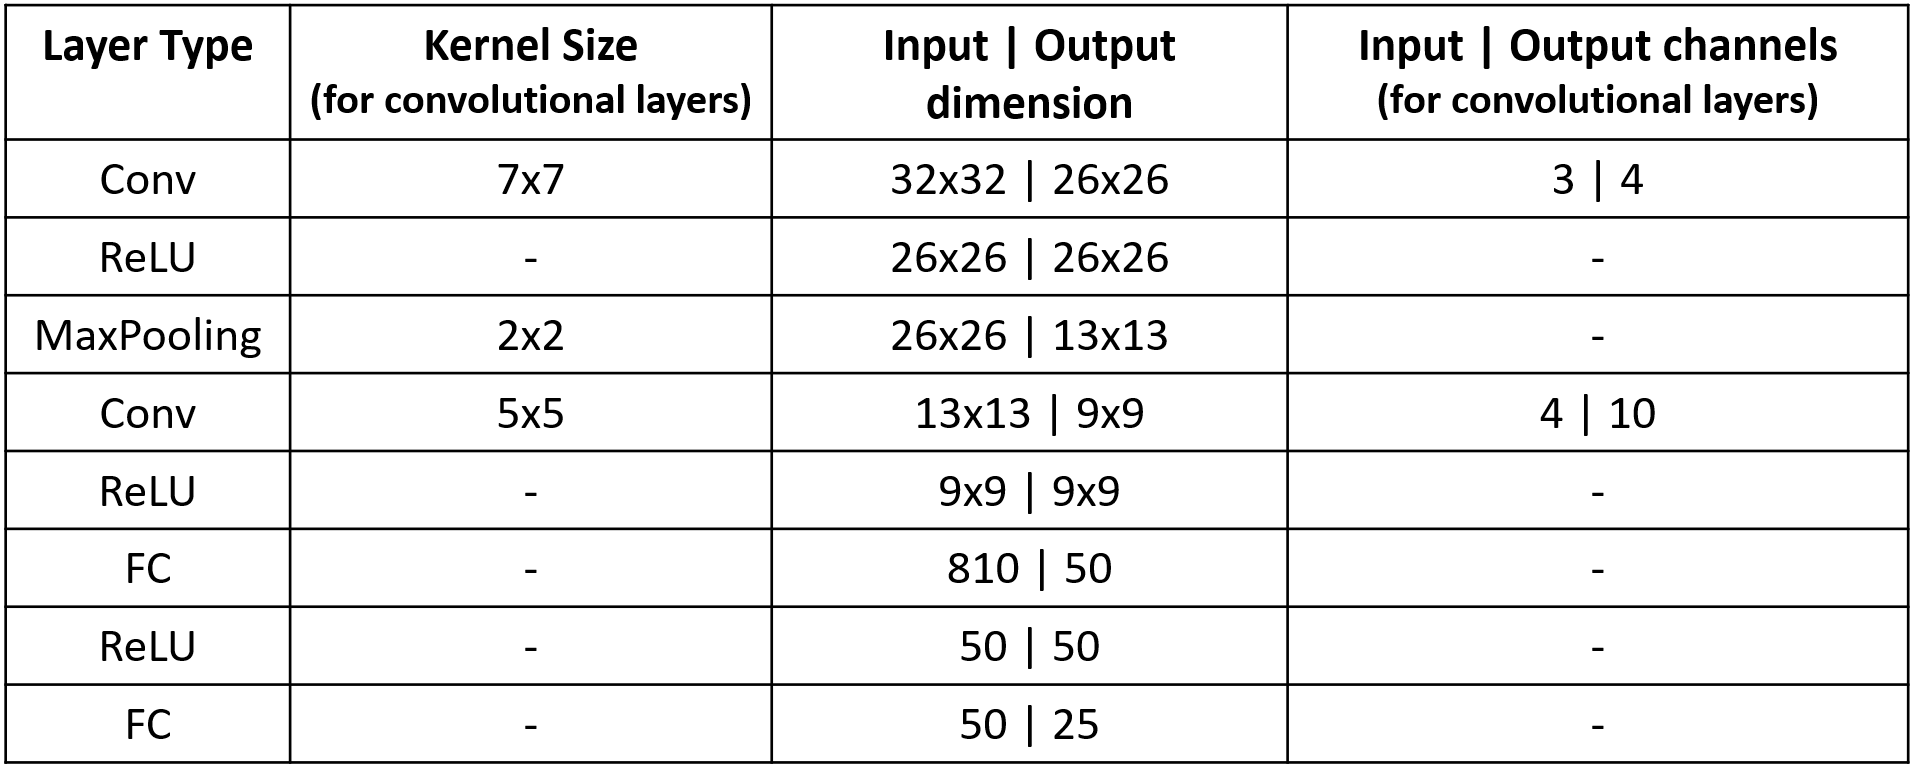


<font color='blue'>The students must:
1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library.
2. Train the model (justifying all decisions made) and evaluate its performance. To do so, you should employ: the confusion matrix in training and testing; the accuracy in training, validation and test; and the evolution of both the loss function (in training and validation) and accuracy (in validation) with respect to the training epochs.

<font color='blue'>Note: This is the base model that we will try to improve in the next section. In this sense, it is not necessary to carry out a very sophisticated or complex training procedure. In any case, it is not advisable to use the default values of functions without having a justification for it. One must demonstrate that he/she understands what is doing, as well as what the framework does underneath.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

#AÑADIDO
print(len(test_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/test'), Path('/root/.fastai/data/cifar100/train')]
[Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_her


"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)." https://github.com/fastai/dlcert2/blob/master/docs/datasets.md

In [ ]:
# We want to verify that within each of the 20 superclasses there are 5 classes,
# which gives the 100 classes there are. We also want to verify that the number of images is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Number of classes within superclass ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/food_containers ):  [Path('/root/.fastai/data/cifar100/train/food_containers/plate'), Path('/root/.fastai/data/cifar100/train/food_containers/can'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle'), Path('/root/.fastai/data/cifar100/train/food_containers/cup'), Path('/root/.fastai/data/cifar100/train/food_containers/bowl')]
Number of classes within superclass  0 :  5
Number of classes within superclass  1 :  5
Number of classes within superclass  2 :  5
Number of classes within superclass  3 :  5
Number of classes within superclass  4 :  5
Number of classes within superclass  5 :  5
Number of classes within superclass  6 :  5
Number of classes within superclass  7 :  5
Number of classes within superclass  8 :  5
Number of classes within superclass  9 :  5
Number of classes within superclass  10 :  5
Number of classes within superclass  11 :  5
Number of classes within superclass  12 :  5
Number of c

In [ ]:
# We keep the first 25 classes (we remove the last 75 from the dataset)
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('REMOVED SUPERCLASSES:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASSES WE KEEP:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

REMOVED SUPERCLASSES:
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/household_furniture
SUPERCLASSES WE KEEP:
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fasta

In [ ]:
# We also remove the classes from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/household_furniture


In [ ]:
# Now we check if we have remove them correctly
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


In [ ]:
# And that the number of examples in training and test is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')

print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/food_containers ):  [Path('/root/.fastai/data/cifar100/train/food_containers/plate'), Path('/root/.fastai/data/cifar100/train/food_containers/can'), Path('/root/.fastai/data/cifar100/train/food_containers/bottle'), Path('/root/.fastai/data/cifar100/train/food_containers/cup'), Path('/root/.fastai/data/cifar100/train/food_containers/bowl')]
Total training images:  12500
Total test images:  2500


Para comenzar con el ejercicio, se va declarar un DataBlock para indicar como se van a tratar los datos de train para después entrenar el modelo con ellos. Un DataBlock es solo un modelo sobre cómo se ensamblan los datos. No hace nada hasta que se le pasa una fuente y se puede optar por convertir esa fuente en un DataSet o en un DataLoader utilizando el método DataBlock.datasets o DataBlock.dataloaders.


+ **blocks**: Especifica los tipos de bloques de datos para las entradas y las etiquetas (ImageBlock para las imágenes y CategoryBlock para las etiquetas categóricas).

+ **get_items**: Especifica una función para obtener la lista de elementos del conjunto de datos (por ejemplo, get_image_files para obtener imágenes a partir de una ruta de una carpeta).

+ **splitter**: Especifica cómo dividir el conjunto de datos en conjuntos de entrenamiento y validación (en este caso, un 10% se usa para validación y la semilla es 33 para asegurar la reproducibilidad). También hay otras particiones posibles pero estas es la que se nos pide en el enunciado.

+ **get_y**: Especifica una función para obtener las etiquetas de los elementos (parent_label en este caso, asumiendo que las etiquetas están en las carpetas padre).

A parte de estos parámetros, hay otros que pueden ser especficados a la hora de crear un DataBlock:
+ **get_x**: Especifica una función para obtener los elementos del DataLoader o el DataSet.

+ **getters**: Funciones get aplicadas a los resultados de get_items.

+ **n_inp**: Número de entradas. Si no se especifica, se fija al máximo entre el número total de bloques menos 1 y la unidad.

+ **item_tfms**: Lista de transformaciones aplicadas por elemento (se hacen en CPU).

+ **batch_tfms**: Lista de transformaciones aplicadas por batch (se hacen en GPU).

+ **dl_type**	TfmdDL 	None 	Task specific TfmdDL, defaults to block’s dl_type orTfmdDL


Algunos de estos parámetros que no se usan en este ejercicio serán discutidos en la siguiente, puesto que se nos pide hacer una prueba con una red básica, dejando el otro ejercicio abierto a posibles mejoras.

In [ ]:
# To be completed by the students

###VALIDATION TRAINING SPLIT

##Lo primero será separar el conjunto de training y tomar un 10% de los datos para validación
##tal y como se indica en el enunciado del ejercicio
db_train = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label
)

# db.summary(path/'train')

dls = db_train.dataloaders(path/'train', bs=32)


Para crear la red neuronal, se hará uso de nn.Sequential. En PyTorch, nn.Sequential es una clase que proporciona una forma conveniente de encapsular un conjunto de capas o módulos en un orden secuencial. Se utiliza para construir modelos de manera sencilla y legible.

A continuación, la práctica se centrará en los parámetros que aquí se usan porque se pide en el enunciado. No obstante, en el ejercicio 2 se explorarán más modulos de nn.

En cuanto a las **convoluciones**, se ha optado por usar el módulo nn.Conv2d. Los parámetros que se le pueden pasar son los siguientes:

+ in_channels (int): número de canales en la imagen de entrada.

+ out_channels (int): número de canales producidos por la convolución.

+ kernel_size (int or tuple): tamaño del kernel de la convolución.

Estos tres parámetros son los únicos que se indican, ya que las dimensiones de la imagen de entrada y salida se tratan automáticamente.

+ stride (int or tuple, optional): stride de la convolución. Por defecto es 1.
+ padding (int, tuple or str, optional): padding añadido a cada borde de la foto. Por defecto es 0.
+ padding_mode (str, optional): 'zeros', 'reflect', 'replicate' o 'circular'. Por defecto: 'zeros'.
+ dilation (int or tuple, optional): espacio entre los elementos del kernel. Por defecto a 1.
+ groups (int, optional) – Number of blocked connections from input channels to output channels. Default 1. PREGUNTAR
+ bias (bool, optional). Si es true, añade un bias a la salida. Por defecto True.

**nn.ReLU** es una capa de activación en PyTorch que implementa la función de activación Rectified Linear Unit (ReLU). La función ReLU es una función no lineal ampliamente utilizada en redes neuronales y se define como:
$ReLU(x)=max⁡(0,x)$

En otras palabras, la función ReLU activa la neurona solo si la entrada es positiva, y si la entrada es negativa, la salida es cero. La función ReLU introduce no linealidad en la red, lo que permite a la red aprender representaciones más complejas y no lineales de los datos.

Solo cuenta con el atributo inplace, que controla si una operación modifica directamente el tensor de entrada o crea uno nuevo.

nn.Flatten aplana un rango continuo de dimensiones en un tensor. Es el primer paso necesario para contar en nuestra red con una capa completamente conectada. Según la documentación oficial:

+ Input: $(∗,S_{start},...,S_i,...,S_{end},∗)$ where $S_i$​ is the size at dimension $i$ and $*$ means any number of dimensions including none.

+ Output: $(∗,\prod_{i=start}^{end}Si,∗)$

Sus parámetros son dos:

+ start_dim (int): primera dimensión a aplanar (default = 1).

+ end_dim (int): última dimensión a aplanar (default = -1).

En nuestro caso, como queremos aplanar todas las dimensiones para contar con únicamente un vector, no se indican parámetros, y por defecto aplana todas las dimensiones.


En cuanto a **nn.linear**, es necesario para reducir las dimensiones de cada capa en la zona completamente conectada. Se encarga de aplicar una trasnformación linear de la forma $y=xA^T+b$. El siguiente dibujo ilustra mucho mejor el comportamiento de esta capa:

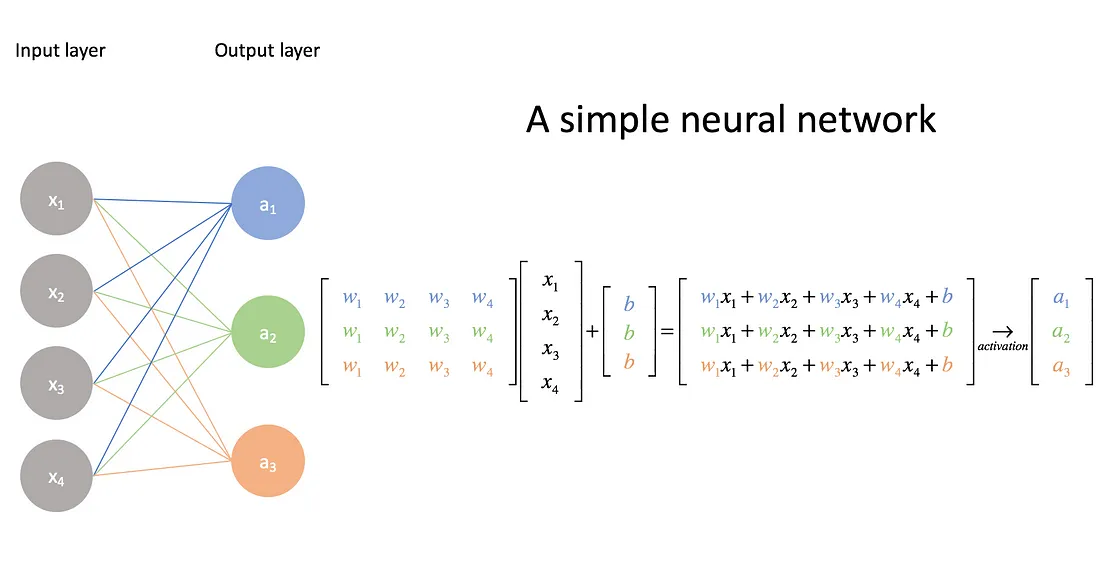





Los parámetros que se pueden indicar son:
+ in_features (int): tamaño de cada entrada.

+ out_features (int): tamaño de cada ejemplo de salida.

+ bias (bool): si es falso, la capa no aprenderá un bias adicional. Por defecto: True.



Importante es también la figura del Learner, lo que nos permite aprender como su nombre indica.

Según la documentación:

Group together a model, some dls and a loss_func to handle training

opt_func will be used to create an optimizer when Learner.fit is called, with lr as a default learning rate. splitter is a function that takes self.model and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is trainable_params, which returns all trainable parameters of the model.

cbs is one or a list of Callbacks to pass to the Learner. Callbacks are used for every tweak of the training loop. Each Callback is registered as an attribute of Learner (with camel case). At creation, all the callbacks in defaults.callbacks (TrainEvalCallback, Recorder and ProgressCallback) are associated to the Learner.

metrics is an optional list of metrics, that can be either functions or Metrics (see below).

path and model_dir are used to save and/or load models. Often path will be inferred from dls, but you can override it or pass a Path object to model_dir. Make sure you can write in path/model_dir!

wd is the default weight decay used when training the model; moms, the default momentums used in Learner.fit_one_cycle. wd_bn_bias controls if weight decay is applied to BatchNorm layers and bias.

Lastly, train_bn controls if BatchNorm layers are trained even when they are supposed to be frozen according to the splitter. Our empirical experiments have shown that it’s the best behavior for those layers in transfer learning.

Es decir, se trata de una puesta a punto del modelo para poder entrenar con él después, según ciertas métricas, funciones callbacks, optimizadores, etc.

In [ ]:
###Creamos el BaseNet desde cero
from torch import nn
import torch.nn.functional as F
import copy

BaseNet = nn.Sequential(
    nn.Conv2d(3,4,7),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(4,10,5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(810, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
)


#Esto nos permitirá crear learners en base a la primera inicialización random de BaseNet al ejecutar la celda
#hubiera bastado con crear nuevos learners cada vez pero para hacer más entendible el código se ha optado
#por almacenarlo en una varaible
# Hacer una copia profunda del modelo original
initial_model = copy.deepcopy(BaseNet)

##El modelo por deepcopy se aloja en cpu y no se puede hacer la comparación después
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
initial_model = initial_model.to(device)

learner = Learner(dls, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
initial_learner = copy.deepcopy(learner)

print(learner.summary())

are_weights_equal = all(torch.allclose(p1, p2, atol=1e-5) for p1, p2 in zip(BaseNet.parameters(), initial_model.parameters()))

if are_weights_equal:
  print("Modelos iguales")



Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 26 x 26    
Conv2d                                    592        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 4 x 13 x 13    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 9 x 9     
Conv2d                                    1010       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 810            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

Se puede observar, con summary, la topología de nuestra red Convolucional. Se ha hecho un pequeño experimento por si hacía falta replicar el modelo más adelante haciendo uso de deepcopy para copiar el modelo.

Se han comentado los parámetros y características de las capas que se han usado. En el siguiente ejercicio, si se añade alguna a la que no se haya hecho referencia aquí, se explicará debidamente.

Notar también que la red ha usado el optimizador Adam por defecto. En este ejercicio no se tocará, pero en el siguiente se probarán otras versiones para ver si hay mejoras. No hay que olvidar que nuestro fin último es minimizar una función de pérdida sin comprometer la generalización del modelo fuera del conjunto de entrenamiento.

Antes de comenzar con la parte del entrenamiento y la discusión de los distintos resultados, me gustaría indicar una pequeña hoja de ruta de lo que se va a hacer.

Lo primero es que se obtendrá un LR a partir de la función lr_find para después usar fit_one_cycle en detrimento de fit para entrenar. Dado que esta obtención de LR se trata de un proceso empírico y nada nos puede hacer saber como obtener un LR óptimo para neustro problema, se ejecutará 5 veces esta búsqueda para estimar un valor prometedor como lr_max, aprovechando además que la forma de realizar el experimento con nuestro modelo puede arrojar distintos resultados entre diferentes ejecuciones.



In [ ]:
doc(learner.lr_find)

Si vemos la documentación de lr_find, dice, literalmente:

+ Lanza un entrenamiento simulado para encontrar una buena tasa de aprendizaje y devuelve sugerencias basadas en suggest_funcs como una tupla con nombres.

  Introducido por Leslie N. Smith en "Cyclical Learning Rates for Training Neural Networks", el buscador de tasas de aprendizaje entrena el modelo con tasas de aprendizaje que crecen de manera exponencial desde start_lr hasta end_lr durante num_it iteraciones, deteniéndose en caso de divergencia (a menos que stop_div=False). Luego, grafica las pérdidas frente a las tasas de aprendizaje con una escala logarítmica.

  Se pueden pasar diversas funciones de sugerencia de tasas de aprendizaje a la función; por defecto, se utiliza el paradigma del valle.

Para las distintas ejecuciones, se dejarán todos los parámetros por defecto excepto el stop_div, que se pondrá a Falso para que la ejecución no termine si el modelo diverge y podamos observar este hecho en la gráfica. Además, se pasarán como suggest_funcs además de valley, minimum, steep y slide.

Realmente, estas funciones siguen un paradigma y devuelven un punto interesante, pero no tiene por qué servirnos de ayuda a la hora de entrenar el modelo. Es por eso que, se han puesto de forma meramente informativa y para ilustrar que FastAI tiene esa capacidad. Además, el ver esos puntos en la gráfica, nos puede ayudar a entender su topología. A continuación, se adjunta la documentación de cada una de estas suggest_functions.

In [ ]:
doc(valley)
doc(minimum)
doc(steep)
doc(slide)

Según los papers asociados a fit_one_cycle y a lr_find, el autor hace diversas pruebas con distintos modelos y datasets, tomando como lr_máximo el LR a partir del cual el modelo, en el experimento de búsqueda de LR, se observa que enmpieza a diverger. En el paper se hace con respecto al accuracy esta búsqueda y en FastAI se muestra con respecto a la pérdida (ambas formas son equivalentes)

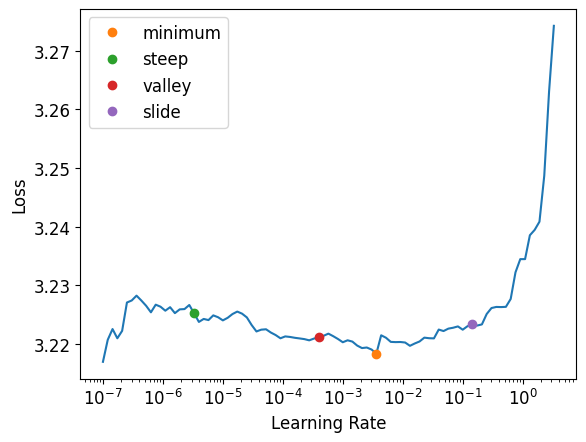

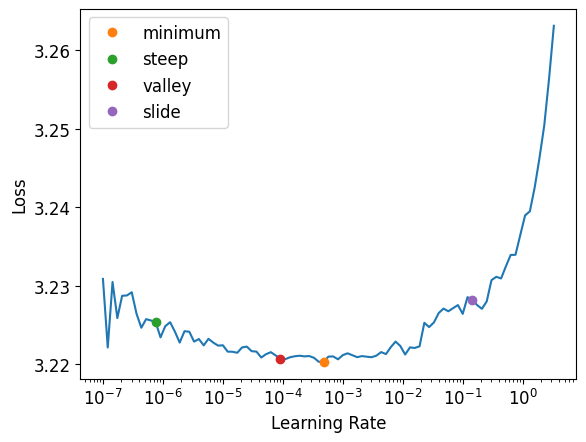

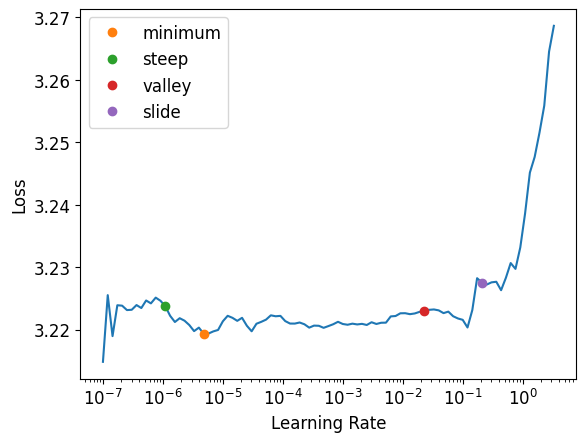

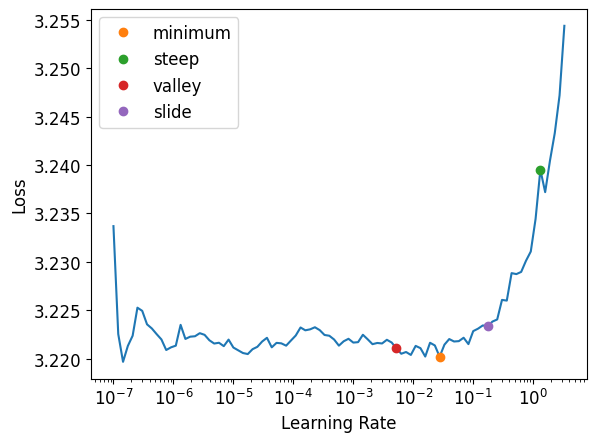

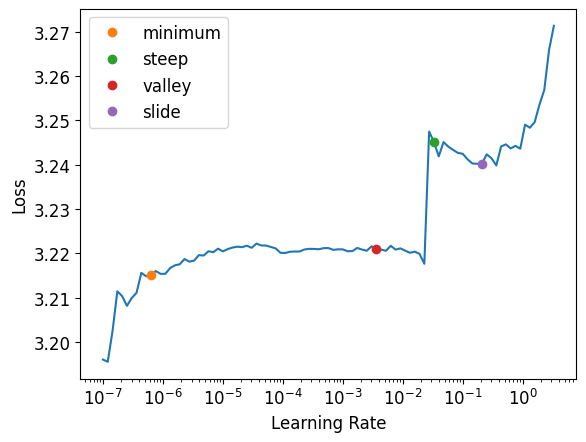

In [ ]:
for i in range(5):
  learner.lr_find(suggest_funcs=(minimum, steep, valley, slide), stop_div=False) # find the maximum value for lr to use in the next call to the optimizer

Observando las distintas gráficas, se puede observar como en casi todas las gráficas se da un comportamiento generalizado de divergencia a partir de un valor de LR = 0.01

In [ ]:
doc(learner.fit_one_cycle)
doc(learner.fit)

La política de ciclo único fue introducida por Leslie N. Smith y otros en "Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates". Esta política programa la tasa de aprendizaje con un enfriamiento coseno desde lr_max/div hasta lr_max, y luego hasta lr_max/div_final (puedes pasar un conjunto de valores a lr_max si deseas utilizar tasas de aprendizaje diferenciales). También programa el momento con un recocido coseno según los valores proporcionados en moms. La primera fase abarca el pct_start del entrenamiento. Opcionalmente, puedes pasar cbs adicionales y reset_opt, si hay que resetear el optimizador.

En general, funciona así:
+ La política de ciclo único implica programar la tasa de aprendizaje durante el entrenamiento de la red. Inicialmente, la tasa de aprendizaje se establece en un valor bajo (lr_max/div), luego aumenta linealmente hasta lr_max durante la primera parte del entrenamiento (pct_start). Después, disminuye cosenoidalmente hasta lr_max/div_final.

+ Además de la tasa de aprendizaje, la técnica ajusta el momento (momentum) de manera similar, siguiendo un patrón cosenoidal. Si no se indican, se usan los momentos por defecto del learner (se puede acceder a ellos con learner.moms).

+ También se puede utilizar tasas de aprendizaje diferenciales, lo que significa que diferentes capas de la red pueden tener tasas de aprendizaje diferentes. Esto puede ser útil para ajustar el aprendizaje en diferentes partes de la red de manera más específica.






In [ ]:
print(learner.moms)
print(learner.cbs)
print(learner.wd)

(0.95, 0.85, 0.95)
[TrainEvalCallback, Recorder, CastToTensor, ProgressCallback]
None


epoch,train_loss,valid_loss,accuracy,time
0,2.777188,2.743356,0.189600,00:15
1,2.676775,2.759374,0.181600,00:14
2,2.707159,2.598653,0.238400,00:13
3,2.670375,2.625809,0.226400,00:14
4,2.534433,2.617729,0.241600,00:15
5,2.444391,2.478863,0.284800,00:15
6,2.271270,2.383970,0.293600,00:15
7,2.130547,2.391433,0.312000,00:15
8,1.998929,2.385721,0.309600,00:15
9,1.907442,2.385620,0.317600,00:14


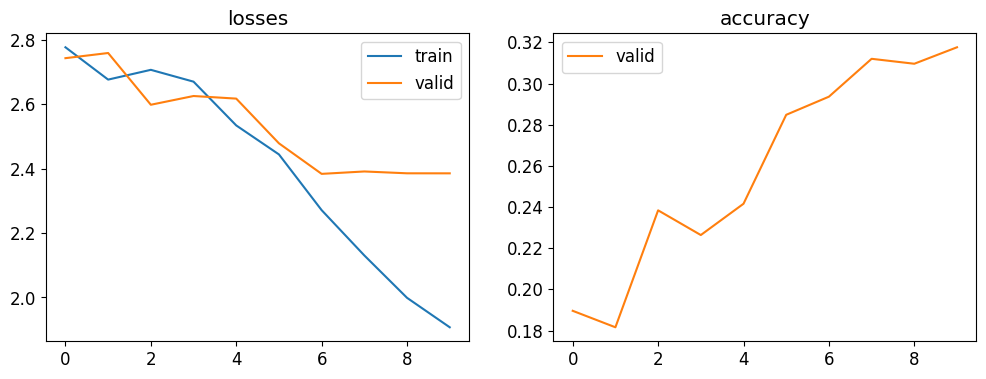

In [ ]:
learner.fit_one_cycle(n_epoch=10, lr_max=0.01)
learner.recorder.plot_metrics()


Viendo el progreso de las pérdidas en train y validación, se puede observar que el modelo empieza a sufrir de sobreajuste a partir de la quinta o la sexta época. A pesar de que la pérdida en train sigue bajando (comportamiento esperado porque es justo lo que se busca con el entrenamiento de las redes), el error en validación se mantiene constante y no baja, por lo que, en el ejercicio 2, además de intentar que la red suba aún más el accuracy en train, hay que intentar que no haya ningún tipo de sobreajuste que merme el desempeño del modelo.

In [ ]:
# We perform prediction on this bunch of data (in this case, the validation set)
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]
test_dl = learner.dls.test_dl(test_files,with_labels=True)

preds, targs, _ = learner.get_preds(dl=test_dl, with_decoded=True)
preds2, targs2, _ = learner.get_preds(dl=dls.train, with_decoded=True)
preds3, targs3, _ = learner.get_preds(dl=dls.valid, with_decoded=True)
# We compute accuracy
acc_test = accuracy(preds, targs)
acc_train = accuracy(preds2,targs2)
acc_valid = accuracy(preds3, targs3)
print('The test accuracy is : ', round(float(acc_test)*100, 4), '%')
print('The train accuracy is : ', round(float(acc_train)*100, 4), '%')
print('The validation accuracy is : ', round(float(acc_valid)*100, 4), '%')

The test accuracy is :  32.28 %
The train accuracy is :  42.6844 %
The validation accuracy is :  31.76 %


Como se podía esperar por los gráficos de la pérdida y el accuracy, el desempeño del modelo es muy pobre. Ante estos resultados, no tiene sentido hacer cambios menores en los parámetros de la función de entrenamiento, ni probar con distintos batch sizes ni otro tipo de experimento. A pesar de que pudieran tener algún impacto, el rendimiento obtenido seguiría siendo pobre (no hay que olvidar que actualmente el accuracy en test es de un 24.16%). Todo apunta, a que, además de añadir complejidad a la red, habrá que encontrar un compromiso con la generalización del modelo para lograr un buen desempeño, y todo ello se discutirá en el siguiente ejercicio.

Number of train examples: 11250


Number of test examples: 2500


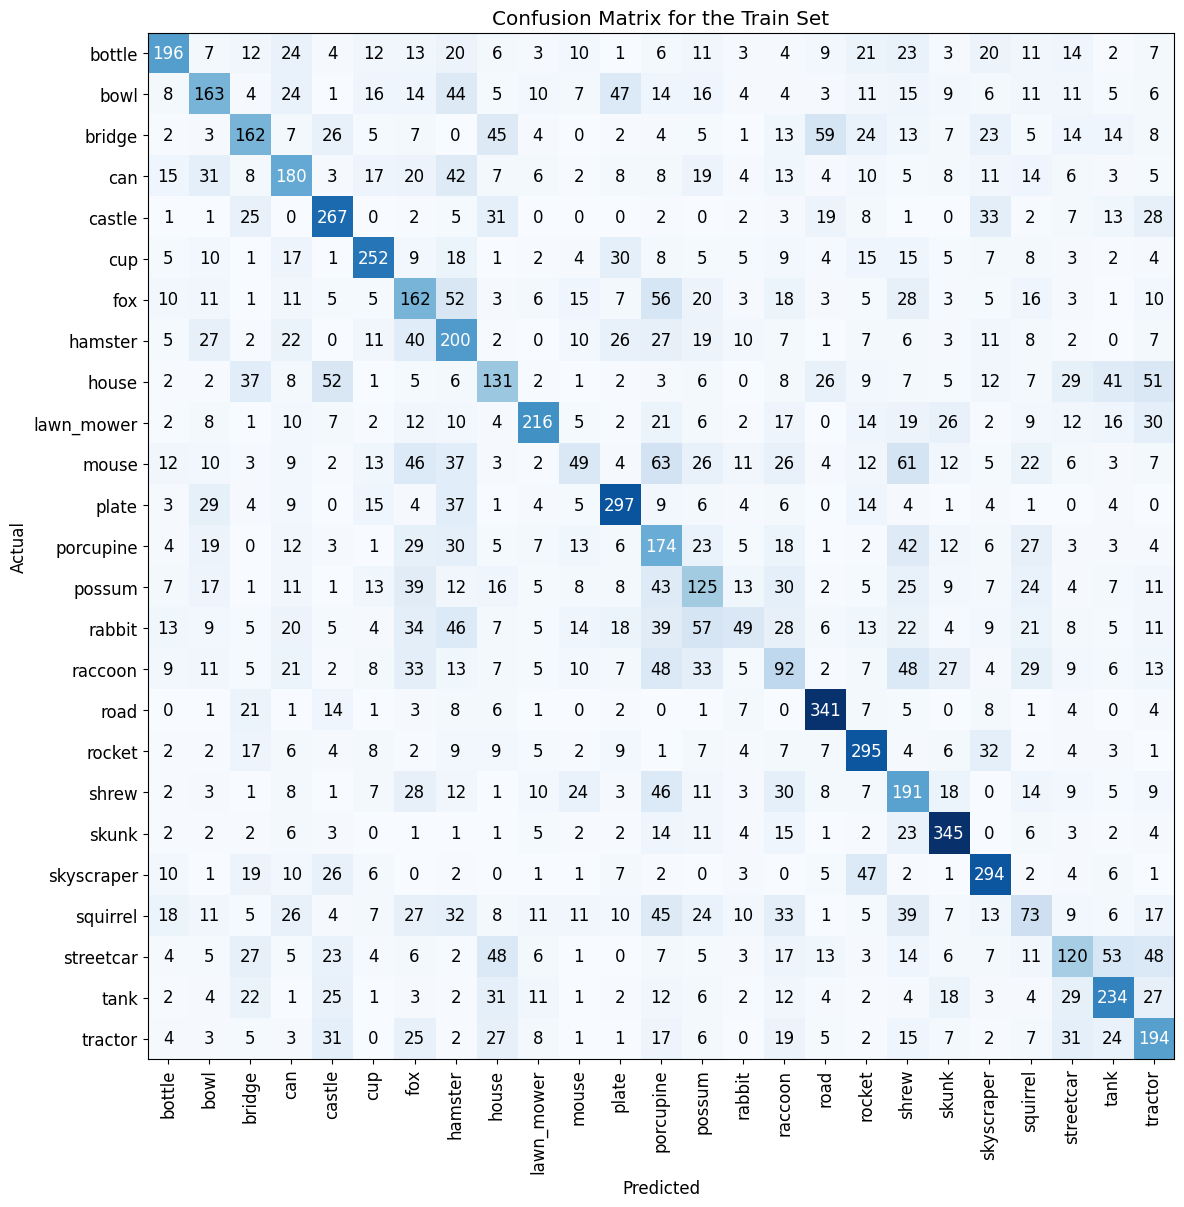

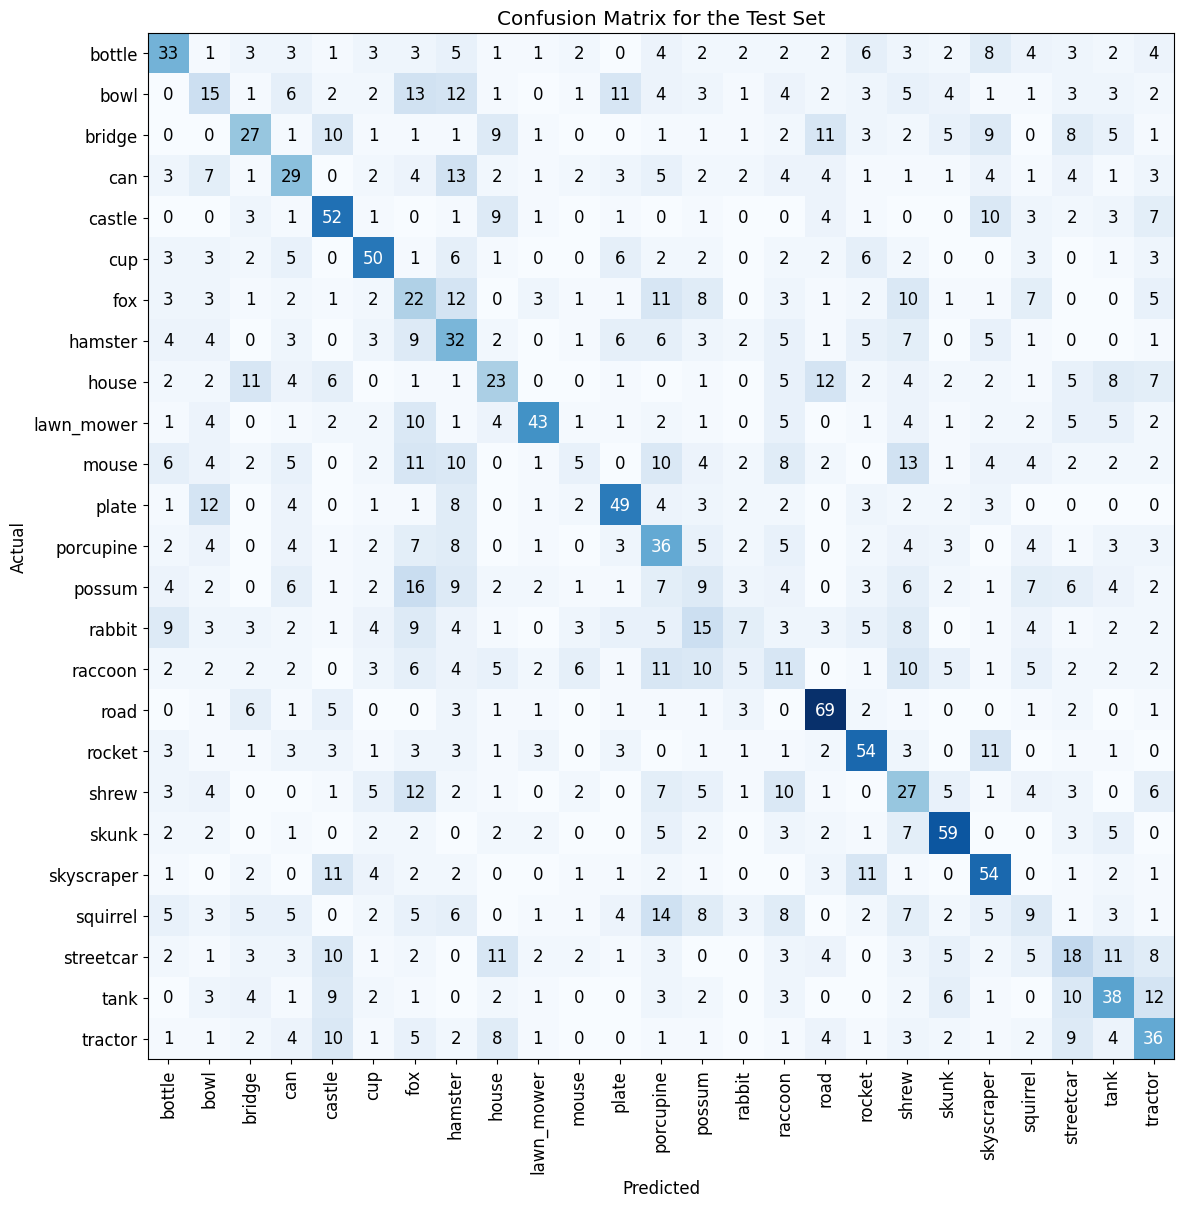

In [ ]:
# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(learner, 1, dls.train)
cm = interp.confusion_matrix()
print('Number of train examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')

# We compute the confusion matrix for test
interp = ClassificationInterpretation.from_learner(learner, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')

Las matrices de confusión no vienen más que a ilustrarnos que el modelo se comporta "mejor" en train que en test, aunque en los dos tienen un desempeño pobre. Los valores en la diagonal principal de ambas matrices nos indican las instancias correctamente etiquetadas por el modelo y todo lo demás, son fallos.

<font color='blue'>What is the total number of parameters of the created model? Break down the account made to reach that figure.



Los parámetros de una capa convolucional se pueden calcular como sigue:
$Parámetros=K \cdot F \cdot F \cdot C_{in}​+K$

Explicación:
+ $K$ es el número de filtros.
+ $F \cdot F$ es el tamaño del filtro.
+ $C_{in}$​ es el número de canales de entrada.
+ $K$ términos adicionales para los sesgos (uno por cada filtro).

$Capa_1 = 4 \cdot 7 \cdot 7 \cdot 3 + 4 = 592$

Las capas de ReLU, MaxPool y Flatten no implican parámetros que la red tenga que aprender.

En cuanto a la siguiente capa convolucional:

$Capa_2 = 10 \cdot 5 \cdot 5 \cdot 4 + 10 = 1010$

La fórmula para calcular los parámetros de una capa lineal es la siguiente:

$Parámetros= N_{current} \cdot (U_{previous}+1)$

Explicación:

+ $N_{current}$:​ es el número de neuronas en la capa totalmente conectada.
+ $U_{previous}$ es el número total de unidades en la capa anterior (convolucional o cualquier otra).
El término $+1$ corresponde al sesgo (bias) asociado a cada neurona en la capa totalmente conectada.

La fórmula tiene en cuenta que cada neurona en la capa totalmente conectada está conectada a cada unidad en la capa anterior, y por lo tanto, hay $N_{current}$ pesos asociados a cada una de las $U_{previous}$ conexiones, además de $N_{current}$ sesgos.

Además, todo esto también se puede inducir de la fórmula que maneja FastAI en la capa lineal. Se va a ilustrar con el cálculo de la primera capa lineal:

$y=xA^T+b$

+ y es de tamaño 1x50
+ x es de tamaño 1x810

Por tanto, $A^T$ deberá tener dimensiones 810x50, lo que resulta en 40500 parámetros. A esto hay que sumarle el sesgo, b tiene dimensiones 1x50, lo cual resulta en 50 parámetros más, 40550 parámetros en total.

Según la formula deberían ser $50 \cdot (810 + 1) = 40550$ parámetros.

En la última capa lineal, hay $25 \cdot (50 + 1) = 1275$ parámetros.

La capa softmax que se realiza automáticamente por usar la función de pérdida CrossEntropyLossFlat, tampoco añade parámetros extras a la red.

Si sumamos todos los parámetros que hemos ido calculando, tenemos un total de:

**${592+1010+40550+1275 = 43427}$ parámetros.**

<font color='blue'>When fastai is used, and a multiclass classification problem like the one indicated in this exercise is addressed, is it necessary to incorporate a SoftMax function (`nn.Softmax()`) as last layer/element/component of your model? Justify the answer.

Como se está utilizando CrossEntropyLossFlat como función de pérdida, no es necesario agregar una capa softmax al final del modelo. La razón es que CrossEntropyLossFlat ya incluye implícitamente la operación softmax en su cálculo.

La función de pérdida CrossEntropyLossFlat combina softmax y la pérdida logarítmica en una sola función. Esta función toma las salidas de la red (antes de softmax) y los objetivos, y realiza internamente la operación softmax antes de calcular la pérdida. Por lo tanto, no es necesario agregar una capa softmax explícita al final del modelo cuando se está utilizando CrossEntropyLossFlat.

Además, antes de esta pregunta, no se incluyó la capa y el modelo clasificaba según las 25 clases, por lo que algo hacía intuir que no era necesario softmax.

In [ ]:
comprobacion = np.array(preds)
print(np.sum(comprobacion,axis=1))

[0.99999994 0.99999994 1.         ... 0.99999994 1.         1.        ]


Como se puede observar, si sumamos cada una de las predicciones, resulta 1, por lo que softmax se ha aplicado aunque no se haya requerido en la capa final de **nn.Sequential**.

Softmax se encarga justamente de asignar una probabilidad de pertenencia a una clase y es ampliamente usada como la última capa de una red neuronal para clasificación en más de una etiqueta (es una generalización de la sigmoide).

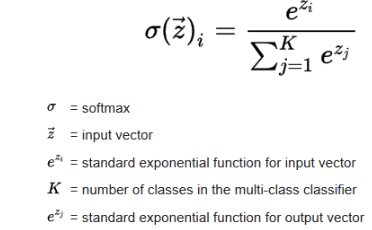

La función softmax realiza dos operaciones clave:

+ Exponenciación de los elementos: Eleva cada elemento del vector de entrada a la potencia de ee, lo cual resalta las diferencias entre los elementos. Esto es útil para convertir números pequeños en números más grandes y resaltar las diferencias relativamente pequeñas.

+ Normalización: Divide cada elemento exponenciado entre la suma de todos los elementos exponenciados. Esto asegura que la salida sea una distribución de probabilidad, ya que la suma de todas las probabilidades resultantes será igual a 1.



---



---



---



# <font color='blue'> **Exercise 2:** **Improvement of the BaseNet model (3.5 points)**
<font color='blue'>Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. Students should perform a sensible combination of different elements, which may include all or some of the following: Convolutional layers (Conv2D, either normal or atrous), Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), Dense layers (also called fully-connected (FC) layers), Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), Flattening (i.e. convert 2D features to 1D features),  Batch Normalization, and/or Regularization (e.g. Dropout or weight decay).

<font color='blue'>It is necessary to emphasize that **it is essential to justify the decisions made in the best possible way** (either through empirical evidence or through scientific literature).

<font color='blue'>A good combination of layers can largely improve the performance of our new model on these data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataLoader or ImageDataLoaders class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that test_transform uses the same normalization parameters as train_transform.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? Keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataLoader or ImageDataLoaders class data zoom parameters, like zoom_range and/or horizontal_flip. Remember that you should not have any data augmentation in the validation or test sets. If you need a better understanding, try reading fastai's tutorial on transformations. Look at data augmentation using image transformations.

<font color='blue'> Feel free to incorporate modifications not included in the aforementioned list.

Antes de comenzar con este ejercicio, indicar que, todas las ejecuciones hasta el apartado MODELO FINAL, son meros experimentos, su ejecución completa alargaría mucho el tiempo en el que la práctica se ejecuta.

El LR se ha ido eligiendo de igual forma que en el ejercicio anterior, se ha optado por usar un batch size de 32 (pequeño, para ver si al final se podía subir y acelerar el entrenamiento) y 50 épocas por experimento con Early Stopping. En los experimentos menos importantes se ha dejado una tolerancia de no mejora de 3 épocas y en los más importantes de 5, para no parar el modelo tan rápido.

Lo primero que no se ha tenido en cuenta en el primer modelo es en contar con las imágenes normalizadas. Esto es fácilmente lograble con FastAI, puesto que existe una función a nivel de batch que se puede indicar en el DataBlock para normalizar según ciertas estadísticas.

Esta función es Normalize.from_stats. Normalizar los datos acelera el entrenamiento y evita posibles sesgos o inconsistencias de la red. Se usará para normalizar según las estadísticas de Imagenet.

También se usará Normalize(), que por defecto usará un batch para calcular los valores según los cuales normalizar para tener desviación 1 y media 0.

In [ ]:
doc(Normalize.from_stats)
doc(Normalize)

Parece lógico pensar que para normalizar, se podría optar por una normalización para que nuestros datos tengan desviación estándar 1 y media 0. No obstante, además de probar este aspecto, se probará a hacer otra técnica ampliamente usada en la literatura, que es normalizar según las desviaciones y media del dataset ImageNet.

Se harán dos pruebas para ver cual de los dos métodos aporta más beneficios. Si no hay diferencias plausibles se optará por usar las stats de ImageNet.

Además de esta normalización, se aplicará también en el primer experimento batch_normalization. Basada en este [paper](https://arxiv.org/abs/1502.03167).
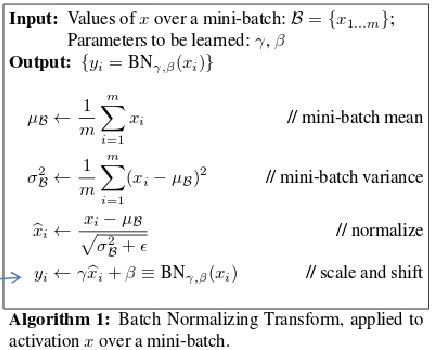



De la última expresión, tenemos los parámetros $γ$ y β, que se aprenderán. Además, $\mu$ y $\sigma^2$ (media y varianza del minibatch) son estadísticas que no se aprenden pero se calculan para su uso. Estos 4 parámetros son para cada capa de normalización.

Gracias a [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167), es sabido que normalizar acelera el entrenamiento. Teniendo en cuenta esto, y que la capa de normalización no añade demasiados parámetros a la red (se demostrará después), se aplicará Batch_Normalization justo antes de la función de activación y también después.

Para ello, se puede usar torch.nn.BatchNorm1D y 2D. La 1D sería para las capas completamente conectadas y la 2D para las capas convolucionales. A continuación, se discutirán los parámetros que tienen estas capas y cuáles no se usarán por defecto (información de la documentación de Torch):
```
torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
```

+ num_features (int) – number of features or channels CC of the input. Se tratará según la capa en la que se aplique.

+ eps (float) – a value added to the denominator for numerical stability. Default: 1e-5. Se dejará por defecto.

+ momentum (float) – the value used for the running_mean and running_var computation. Can be set to None for cumulative moving average (i.e. simple average). Default: 0.1. Se dejará por defecto.

+ affine (bool) – a boolean value that when set to True, this module has learnable affine parameters. Default: True. Se dejará por defecto.

+ track_running_stats (bool) – a boolean value that when set to True, this module tracks the running mean and variance, and when set to False, this module does not track such statistics, and initializes statistics buffers running_mean and running_var as None. When these buffers are None, this module always uses batch statistics. in both training and eval modes. Default: True. Este tiene que estar a True para que sea consistente con la teoría, así que se deja por defecto.

Para 2D es exactamente igual, lo único que num_features cambia su definición por num_features (int) – C from an expected input of size (N,C,H,W).

Por último y en vista a la pobre generalización del modelo del ejercicio 1, también se probará con data_augmentation en ambos experimentos con las estadísticas de normalización.

La forma más sencilla de aplicar esta idea es usando la función aug_transforms con los parámetros adecuados. Además, por como funciona internamente FastAI, se garantiza que esta transformación se ejecuta solo en Train, no en Validación. (Esto será demostrado más tarde).

A continuación, se van a discutir los distintos parámetros de aug_transforms.






In [ ]:
doc(aug_transforms)

+ mult: Factor multiplicativo aplicado a max_rotate, max_lightning y max_warp. Se dejará por defecto a 1.

+ do_flip: ejecuta un volteo aleatorio. Por defecto está a True.

+ flip_vert: si está activado y también lo está do_flip, en vez de un volteo aleatorio se hace un dihedral (8 vistas de la imagen en todos los sentidos horizontales y verticales). Se pondrá a True.

+ max_rotate: maximo grado de rotación, se dejará por defecto a 10.

+ min_zoom: el zoom mínimo, por defecto está a 1.0 y se dejará así.

+ max_zoom: zoom máximo, por defecto está a 1.1. Con la probabilidad que se comentará despues denominada p_affine, se hace un zoom random de un valor entre min y max. Se dejará también por defecto.

+ max_lighting: maxima escala para cambiar el brillo. Por defecto está a 0.2. Con la probabilidad p_lighting se aplica un cambio en el brillo y elcontraste de este valor. También se dejará por defecto.

+ max_warp: maximo valor para cambiar la perspectiva. Con probabilidad p_affine, se hace un cambio de perspectiva en la imagen de este valor. Se deja por defecto a 0.2.

+ p_affine: probabilidad de realizar las transformaciones afines (rotación, zoom, warp). Se deja por defecto a 0.75.

+ p_lighting: probabilidad de cambiar el brillo y el contraste. Se deja por defecto a 0.75.

+ xtra_tfms: transformaciones personalizadas. No se usarán.

+ size: tamaño de salida. Se le indica ancho y alto, si solo se indica un número, se toma duplicado. Por defecto es none y se dejará así.

+ mode: modo de interpolación. Se deja por defecto a bilineal.

+ pad_mode: forma en que se hace el padding. Se deja en reflection por defecto.

  Estas tres anteriores se usan para la interpolación.

+ align_corners: por defecto a True.

+ batch: aplicar la misma transformación al batch entero. Por defecto se deja a False.

+ min_scale: escala mínima de recorte en relación con el área de la imagen. Se deja por defecto a 1.0.

In [ ]:
db_train_p1_imagenet= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
)

mean,std = [0]*3,[1]*3
mean,std = broadcast_vec(1, 4, mean, std)
db_train_p1_std_dist = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True), Normalize()]
)

dls_p1_imagenet = db_train_p1_imagenet.dataloaders(path/'train', bs=32)
dls_p1_std_dist  = db_train_p1_std_dist.dataloaders(path/'train', bs=32)

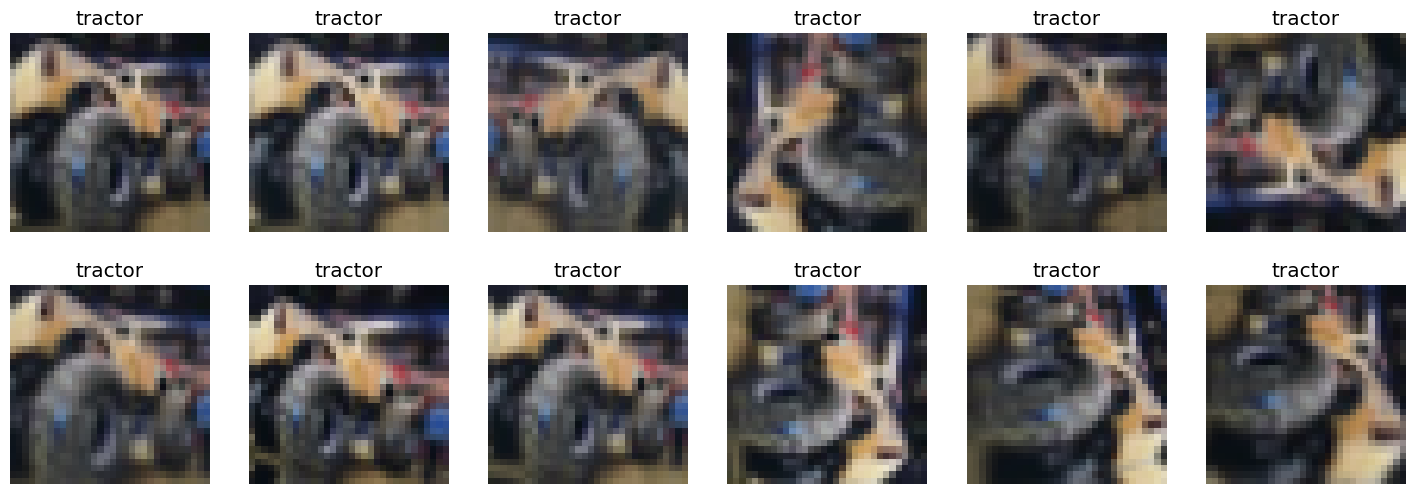

In [ ]:
dls_p1_imagenet.train.show_batch(max_n = 12, nrows = 2, unique = True)

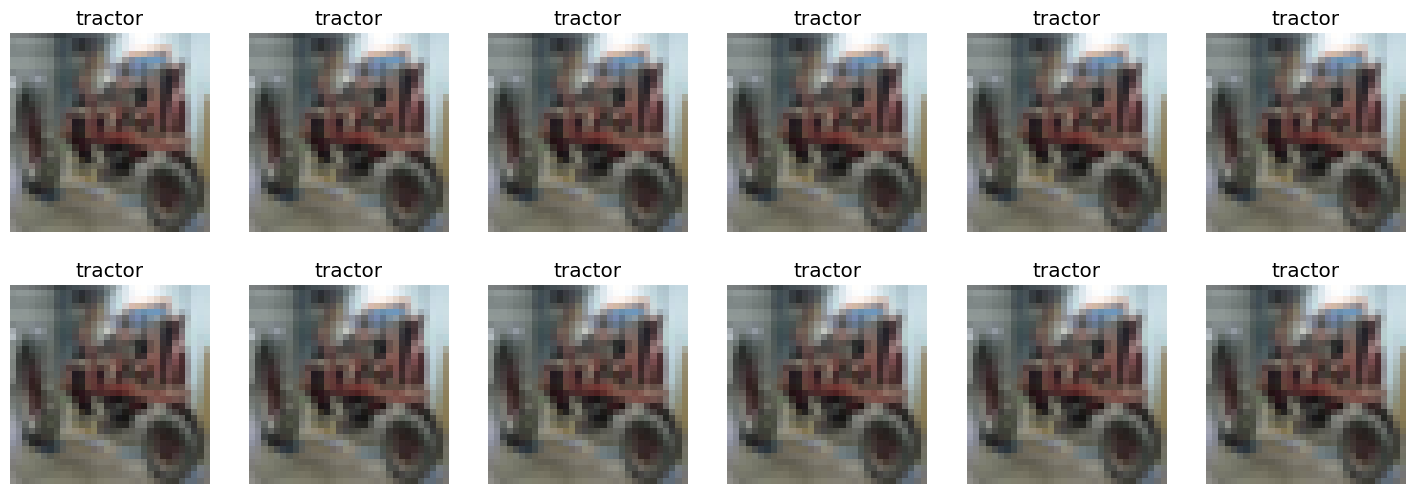

In [ ]:
dls_p1_imagenet.valid.show_batch(max_n = 12, nrows = 2, unique = True )

Tras consultar foros de FastAI, se determinó que cualquier cosa que no fuera un resize dentro de aug_transforms, no se aplica a validación, solo a Train. Así que, la prueba anterior, con Unique a True para que solo muestre el mismo tipo de imagen, se puede observar como en Train se aprecian trasnformaciones y en Validación la misma imagen.

En cuanto a la normalización, sí que se aplica en los dos conjuntos, la prueba está a continuación.

In [ ]:
x,y = dls_p1_imagenet.train.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.2016, 0.2576, 0.3168], device='cuda:0'),
 TensorImage([1.0979, 1.1502, 1.2313], device='cuda:0'))

In [ ]:
x,y = dls_p1_std_dist.train.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0745, -0.0640, -0.0469], device='cuda:0'),
 TensorImage([0.9794, 0.9594, 0.9928], device='cuda:0'))

In [ ]:
x,y = dls_p1_imagenet.valid.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.1280, 0.1860, 0.1314], device='cuda:0'),
 TensorImage([1.1032, 1.1060, 1.2066], device='cuda:0'))

In [ ]:
x,y = dls_p1_std_dist.valid.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.1255, -0.0752, -0.2131], device='cuda:0'),
 TensorImage([0.9329, 0.9060, 0.9819], device='cuda:0'))

La normalización con las estadísticas de Imagenet sorprendéntemente no se aleja de la otra, donde se fuerza a que sea media 0 y desviación 1. No obstante, se optará por una forma u otra según una prueba de entrenamiento.

Estos códigos realizan las siguientes operaciones:

+ x, y = dls_p1_std_dist.train.one_batch(): Se extrae un lote de datos y etiquetas (x y y, respectivamente) del conjunto de entrenamiento (train) (o validación) del DataLoader llamado dls_p1_std_dist. Este lote representa un conjunto de datos y etiquetas que se utilizarán para el entrenamiento del modelo.

+ x.mean(dim=[0,2,3]): Calcula la media a lo largo de las dimensiones 0, 2 y 3 del tensor x.
La dimensión 0 generalmente representa el índice del lote en un tensor de imágenes.
Las dimensiones 2 y 3 son las dimensiones espaciales de la imagen, como altura y ancho.

  Por lo tanto, este cálculo de la media proporcionará un tensor que contiene las medias de cada canal de color a través de todas las imágenes en el lote y a lo largo de las dimensiones espaciales.

+ x.std(dim=[0,2,3]): Calcula la desviación estándar a lo largo de las mismas dimensiones (0, 2, y 3) que se explicaron anteriormente.

  Este cálculo proporcionará un tensor que contiene las desviaciones estándar de cada canal de color a través de todas las imágenes en el lote y a lo largo de las dimensiones espaciales.

Como se puede observar, la media es 0 y las desviaciones 1, aproximadamente.

In [ ]:
BaseNet = nn.Sequential(
    nn.Conv2d(3,4,7),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(4,10,5),
    nn.BatchNorm2d(10),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(810, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, 25),
)
BaseNet_ini = copy.deepcopy(BaseNet)
BaseNet2 = nn.Sequential(
    nn.Conv2d(3,4,7),
    nn.ReLU(),
    nn.BatchNorm2d(4),
    nn.MaxPool2d(2),

    nn.Conv2d(4,10,5),
    nn.ReLU(),
    nn.BatchNorm2d(10),

    nn.Flatten(),
    nn.Linear(810, 50),
    nn.ReLU(),
    nn.BatchNorm1d(50),

    nn.Linear(50, 25),
)

BaseNet2_ini = copy.deepcopy(BaseNet2)

learner1 = Learner(dls_p1_imagenet, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learner2 = Learner(dls_p1_std_dist, BaseNet_ini, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learner3 = Learner(dls_p1_imagenet, BaseNet2, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learner4 = Learner(dls_p1_std_dist, BaseNet2_ini, loss_func = CrossEntropyLossFlat(), metrics = accuracy)


In [ ]:
num_params = sum(p.numel() for p in learner.model.parameters())
print(f"Número total de parámetros en el modelo del ejercicio 1: {num_params}")
num_params = sum(p.numel() for p in learner1.model.parameters())
print(f"Número total de parámetros en el modelo 1 tras BN: {num_params}")

Número total de parámetros en el modelo del ejercicio 1: 43427
Número total de parámetros en el modelo 1 tras BN: 43555


Se han añadido exactamente los mismos parámetros en estos cuatro learners (el tipo de normalización y si va antes o después no afecta).

En total, han sido $43555 - 43427 = 128$

Si vemos el summary del Learner del ejercicio anterior, y tenemos en cuenta que se ha añadio BN en la primera capa de transformaciones, en la tercera y en la quinta, se puede deducir fácilmente el número de parámetros nuevo.



In [ ]:
print(learner.summary())
learner1.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 26 x 26    
Conv2d                                    592        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 4 x 13 x 13    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 9 x 9     
Conv2d                                    1010       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 810            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 26 x 26    
Conv2d                                    592        True      
BatchNorm2d                               8          True      
ReLU                                                           
____________________________________________________________________________
                     32 x 4 x 13 x 13    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 9 x 9     
Conv2d                                    1010       True      
BatchNorm2d                               20         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 810            
Flatten                                       

Sabiendo que tenemos 2 parámetros por cada capa de normalización (los otros dos se calculan) y que en la primera tendríamos 4, en la tercera capa 10 y en la quinta 50:

$4 \cdot 2 + 10 \cdot 2 + 50 \cdot 2 = 128$

## PRUEBAS NORMALIZACIÓN Y POSICIÓN BN

SuggestedLRs(valley=0.001737800776027143)

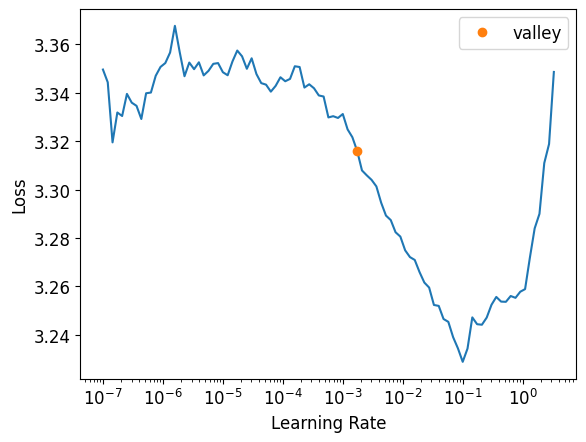

In [ ]:
learner1.lr_find(stop_div = False)

SuggestedLRs(valley=0.007585775572806597)

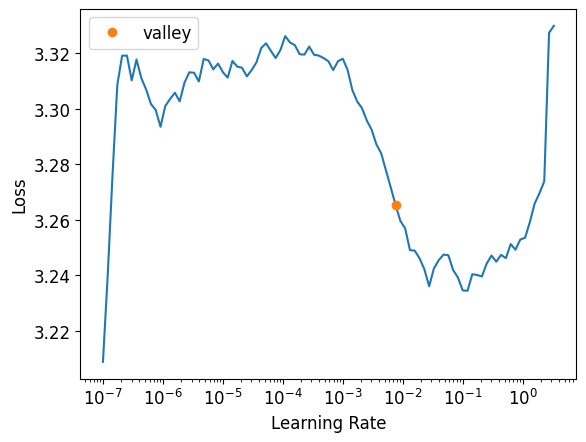

In [ ]:
learner2.lr_find(stop_div = False)

SuggestedLRs(valley=0.005248074419796467)

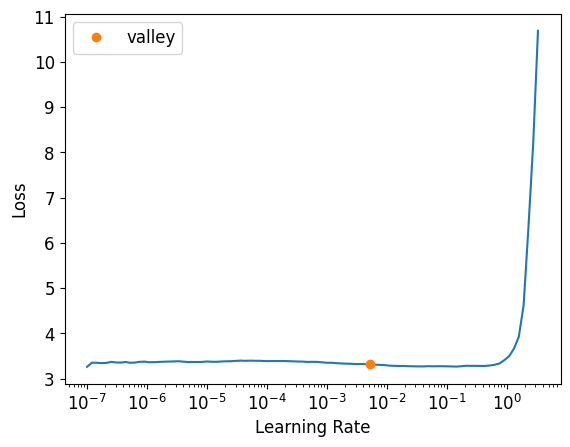

In [ ]:
learner3.lr_find(stop_div = False)

SuggestedLRs(valley=0.005248074419796467)

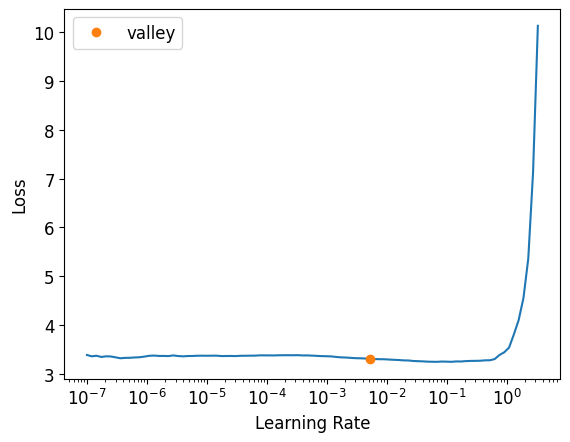

In [ ]:
learner4.lr_find(stop_div = False)

Parece adecuado según la prueba de búsqueda de LR, hacer el experimento con un LR de $10^{-3}$.

Para reducir al máximo posible el entrenamiento, se usará Early Stopping. En FastAI se implementa como un callback que se puede pasar a la función de entrenamiento. Según los parámetros que se han indicado, si durante 3 épocas, el error en validación no mejora 0.01, se para de entrenar.

Recordar que tenemos cuatro learners. Los dos primeros implementan BN antes de la función de activación y usan la normalización según las estadísticas de Imagenet y forzando a que sea media 0 y desviación 1, respectivamente. Los dos últimos Learners usan BN después de la función de activación.

epoch,train_loss,valid_loss,accuracy,time
0,3.136452,3.080202,0.104000,00:20
1,3.005701,2.931503,0.166400,00:21
2,2.890293,2.772144,0.221600,00:19
3,2.763368,2.625594,0.270400,00:19
4,2.670124,2.519480,0.286400,00:19
5,2.592042,2.430990,0.287200,00:20
6,2.553514,2.372115,0.312800,00:22
7,2.522752,2.371592,0.298400,00:22
8,2.457458,2.286487,0.316800,00:19
9,2.423697,2.188565,0.356800,00:19


No improvement since epoch 18: early stopping


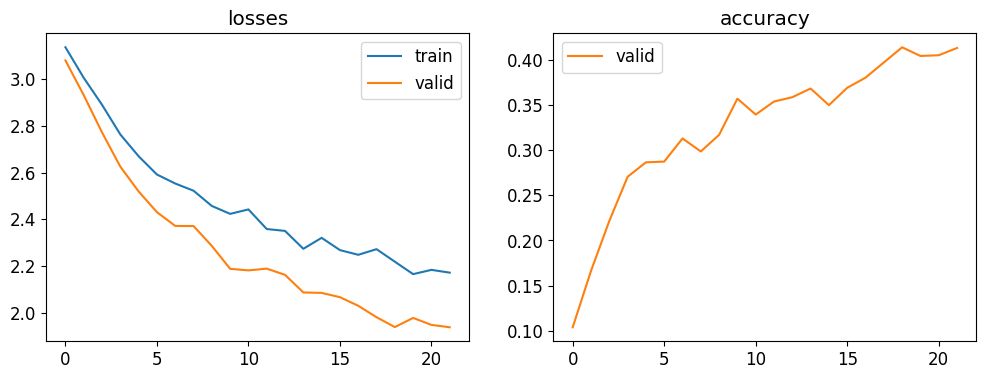

In [ ]:

early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)
learner1.fit_one_cycle(n_epoch=50, lr_max=10**-3, cbs=[early_stopping_cb])
learner1.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,3.135004,3.078673,0.104000,00:19
1,2.994252,2.938552,0.170400,00:21
2,2.895542,2.776098,0.220800,00:21
3,2.761505,2.623194,0.259200,00:38
4,2.649368,2.491480,0.284800,00:40
5,2.601275,2.418410,0.278400,00:25
6,2.568159,2.374823,0.292000,00:22
7,2.536350,2.336265,0.304000,00:20
8,2.502130,2.310865,0.315200,00:19
9,2.458625,2.275218,0.329600,00:20


No improvement since epoch 10: early stopping


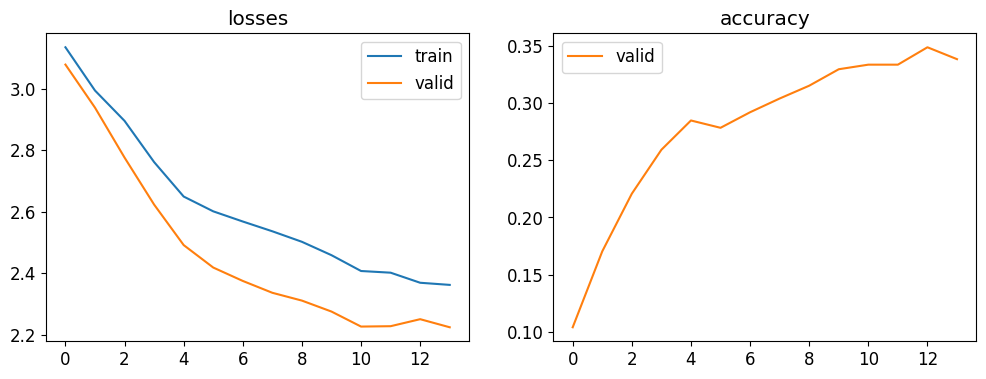

In [ ]:
learner2.fit_one_cycle(n_epoch=50, lr_max=10**-3, cbs=[early_stopping_cb])
learner2.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,3.108997,3.031228,0.126400,00:23
1,2.972167,2.868375,0.193600,00:20
2,2.857216,2.699667,0.241600,00:19
3,2.752309,2.576766,0.264000,00:19
4,2.651577,2.461427,0.298400,00:19
5,2.614386,2.374870,0.313600,00:21
6,2.569201,2.303315,0.327200,00:21
7,2.512165,2.274507,0.327200,00:19
8,2.456934,2.233518,0.344800,00:19
9,2.441922,2.182279,0.352800,00:22


No improvement since epoch 17: early stopping


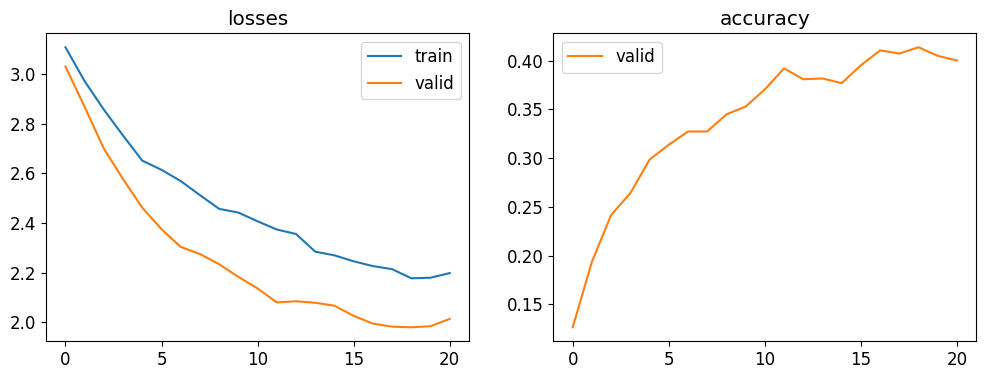

In [ ]:
learner3.fit_one_cycle(n_epoch=50, lr_max=10**-3, cbs=[early_stopping_cb])
learner3.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,3.130593,3.028661,0.134400,00:21
1,2.962637,2.846414,0.204800,00:20
2,2.823159,2.683537,0.247200,00:19
3,2.779922,2.553635,0.279200,00:19
4,2.653952,2.493184,0.276800,00:20
5,2.588169,2.391090,0.298400,00:21
6,2.571682,2.308865,0.325600,00:21
7,2.507147,2.271650,0.334400,00:23
8,2.457438,2.241821,0.337600,00:19
9,2.423942,2.196917,0.368000,00:19


No improvement since epoch 27: early stopping


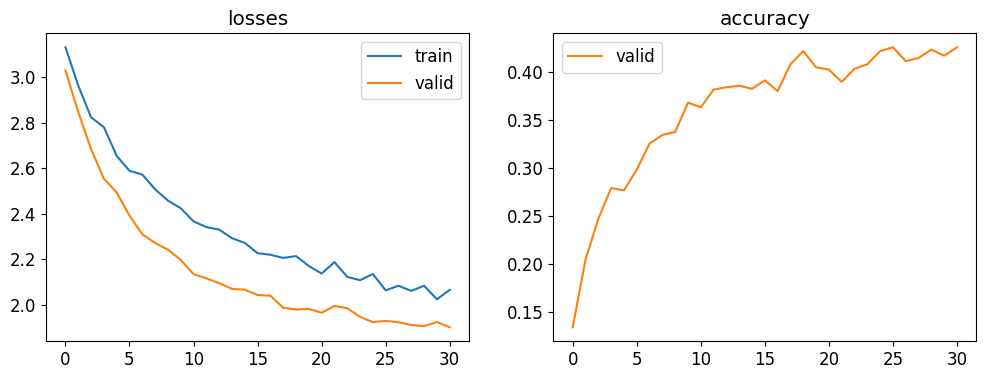

In [ ]:
learner4.fit_one_cycle(n_epoch=50, lr_max=10**-3, cbs=[early_stopping_cb])
learner4.recorder.plot_metrics()

Los resultados son parecidos, así que se optará por dejar BN antes de la función de activación y a normalizar según las stats de Imagenet.


##PRUEBA CON DATA AUGMENTATION MÁS AGRESIVO

A continuación, se va a realizar un experimento con un Data Augmentation más extendido. Esto se conseguirá indicando que las transformaciones afines y las de luminosidad de aplicarán con probabilidad de 1.

In [ ]:
db_train_p1_aug= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True, p_affine=1, p_lighting=1), Normalize.from_stats(*imagenet_stats)]
)
dls_p1_aug = db_train_p1_aug.dataloaders(path/'train', bs=32)

BaseNet3 = nn.Sequential(
    nn.Conv2d(3,4,7),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(4,10,5),
    nn.BatchNorm2d(10),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(810, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, 25),
)

learner_aug = Learner(dls_p1_aug, BaseNet3, loss_func = CrossEntropyLossFlat(), metrics = accuracy)


SuggestedLRs(valley=0.013182567432522774)

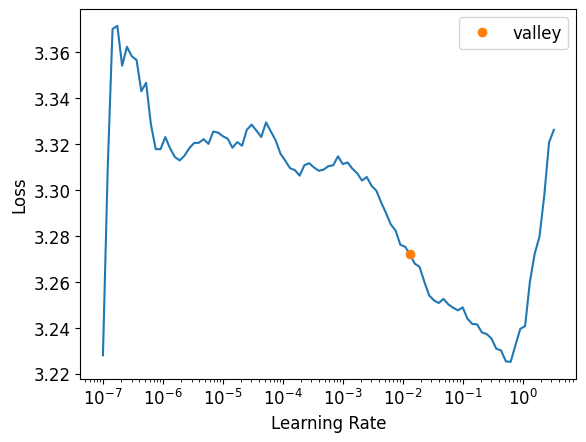

In [ ]:
learner_aug.lr_find(stop_div = False)

En vista a la gráfica, parece lógico usar un LR de $10^{-2}$

epoch,train_loss,valid_loss,accuracy,time
0,2.868519,2.726444,0.224800,00:19
1,2.709611,2.533263,0.231200,00:19
2,2.672262,2.446740,0.272800,00:19
3,2.603998,2.434984,0.260800,00:21
4,2.544220,2.329187,0.306400,00:20
5,2.519106,2.353381,0.304800,00:22
6,2.496516,2.297282,0.306400,00:19
7,2.462426,2.261536,0.307200,00:19
8,2.451463,2.307794,0.298400,00:20
9,2.452564,2.162429,0.360800,00:20


No improvement since epoch 9: early stopping


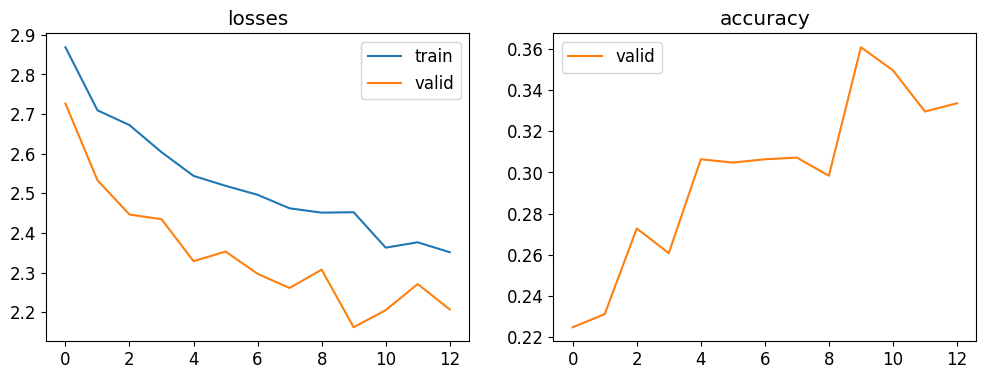

In [ ]:
learner_aug.fit_one_cycle(n_epoch=50, lr_max=10**-2, cbs=[early_stopping_cb])
learner_aug.recorder.plot_metrics()

Dado su parecido a las ejecuciones anteriores y que no ha conseguido mejorar los resultados se descartará esta forma de Data Augmentation y se procederá como con los modelos anteriores, con las probabilidades que se han puesto a 1 con 0.75 de valor.

##PRUEBA CON MÁS CAPAS CONVOLUCIONALES Y MÁS CANALES

Si nos fijamos en el Accuracy del modelo, sigue siendo muy pobre. Llegados a este punto, parece lógico pensar en añadir una gran cantidad de parámetros a la red para que pueda hacer una representación más compleja de la función objetivo. Para implementar esta idea, se usarán 4 convoluciones 2D con un kernel 3x3. La primera convolución pasará de 3 a 128 canales y cada convolución restante multiplicará el número de canales por 2.

In [ ]:
BaseNet4 = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(82944, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, 25),
)


learner_3x3 = Learner(dls_p1_imagenet, BaseNet4, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

In [ ]:
learner_3x3.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 128 x 30 x 30  
Conv2d                                    3584       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 128 x 15 x 15  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 256 x 13 x 13  
Conv2d                                    295168     True      
BatchNorm2d                               512        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 512 x 11 x 11  
Conv2d                                    1180

Esta nueva arquitectura, tiene significativamente más parámetros que la anterior, por lo que a priori debería representar mejor la complejidad de la función objetivo. No obstante, esto puede ser perjudicial en términos de overfitting.

SuggestedLRs(valley=0.004365158267319202)

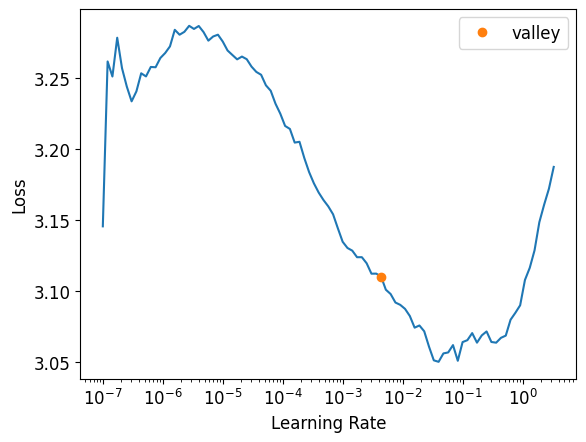

In [ ]:
learner_3x3.lr_find(stop_div = False)

Parece adecuado usar un LR de $10^{-3}$ como LR máximo, dado que se encuentra en una zona donde la función de pérdida se ha minimizado con bastante pendiente.

En esta prueba, se ha dejado igual el Early Stopper pero con una paciencia de 5 épocas en vez de 3, para no cortar el entrenamiento tan pronto.

epoch,train_loss,valid_loss,accuracy,time
0,2.736793,2.566282,0.335200,00:22
1,2.568166,2.356613,0.356000,00:25
2,2.419513,2.140410,0.410400,00:24
3,2.261103,1.992265,0.432800,00:22
4,2.075037,1.804922,0.465600,00:24
5,1.935351,1.708925,0.474400,00:23
6,1.927144,1.882109,0.454400,00:22
7,1.818592,1.656767,0.508800,00:24
8,1.776748,1.524390,0.542400,00:22
9,1.691821,1.535892,0.537600,00:22


No improvement since epoch 26: early stopping


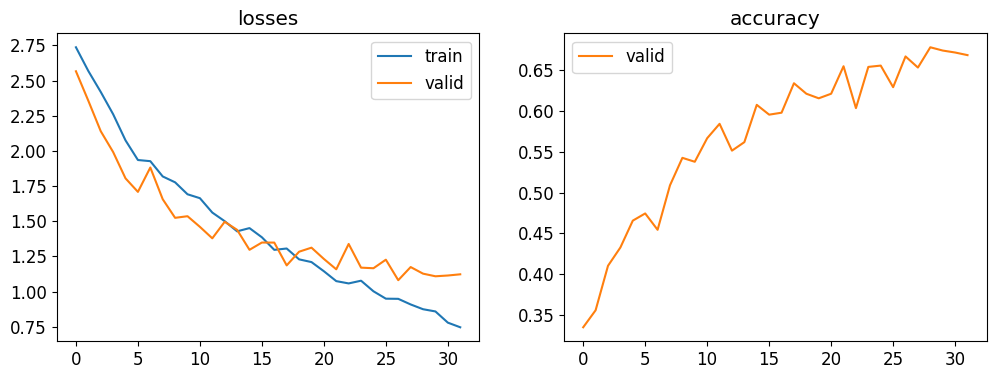

In [ ]:
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)
learner_3x3.fit_one_cycle(n_epoch=50, lr_max=10**-3, cbs=[early_stopping_cb])
learner_3x3.recorder.plot_metrics()

Como se puede observar, el rendimiento estaba siendo bueno pero la red a comenzado a sobreajustar.

En este punto, se podría probar con la idea descartada de un Data Augmentation más ampliado con miras a paliar el sobreajuste o, intentar introducir Dropout en la capa completamente conectada, que es la que se va a aplicar.

La idea detrás de Dropout es "apagar" aleatoriamente un conjunto de unidades (neuronas) durante el entrenamiento. Esto ayuda a evitar que las unidades dependan demasiado entre sí y, por lo tanto, reduce la tendencia del modelo a sobreajustarse a los datos de entrenamiento específicos. Dropout proporciona una especie de promedio de múltiples modelos más pequeños que comparten parámetros, lo que mejora la generalización del modelo.

##PRUEBA CON DROPOUT

In [ ]:
doc(nn.Dropout)

En este caso, se usará con los parámetros por defecto.

In [ ]:
BaseNet5 = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),


    nn.Flatten(),
    nn.Linear(82944, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, 25),
)


learner_3x3_2 = Learner(dls_p1_imagenet, BaseNet5, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

SuggestedLRs(valley=0.0006918309954926372)

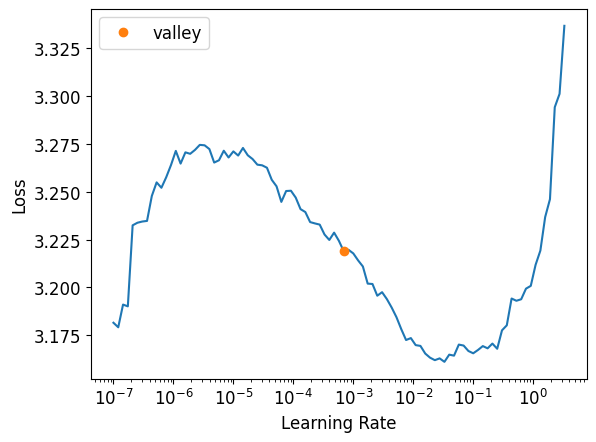

In [ ]:
learner_3x3_2.lr_find(stop_div=False)

También parece adecuado usar un LR Máximo como en la prueba anterior.

epoch,train_loss,valid_loss,accuracy,time
0,2.981205,2.825281,0.232800,00:22
1,2.846406,2.689302,0.324000,00:24
2,2.775046,2.616508,0.336000,00:26
3,2.658936,2.435577,0.356800,00:23
4,2.516392,2.241118,0.420000,00:25
5,2.382385,2.146521,0.386400,00:22
6,2.301981,1.868358,0.469600,00:24
7,2.213539,1.972294,0.397600,00:23
8,2.155234,1.904415,0.446400,00:22
9,2.081098,1.890553,0.427200,00:25


No improvement since epoch 20: early stopping


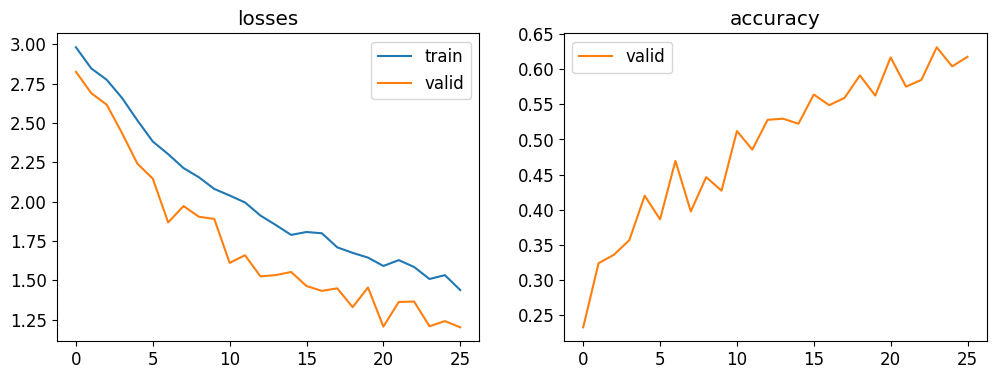

In [ ]:
learner_3x3_2.fit_one_cycle(n_epoch=50, lr_max=10**-3, cbs=[early_stopping_cb])
learner_3x3_2.recorder.plot_metrics()

El modelo ha generalizado mejor logrando casi idéntico Acc en validación. Se ha recortado un poco su rendimiento en cuanto a optimizador del error en el conjunto Train pero no se obtiene overfitting. Será un buen punto de partida para posibles mejoras posteriores.

##PRUEBA CON 1 CAPA LINEAL MÁS EN LA CAPA COMPLETAMENTE CONECTADA

A continuación, se probará a añadir otra capa lineal en la capa completamente conectada, al estilo de la que automáticamente se crea en FastAI cuando creas una cabecera por defecto para hacer fine_tuning de un modelo. Se dejará Dropout en vista a la mejora de rendimiento que nos ha otorgado.

In [ ]:
BaseNet6 = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),


    nn.Flatten(),
    nn.Linear(82944, 1024),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(1024),
    nn.ReLU(),

    nn.Linear(1024, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, 25),
)


learner_fc = Learner(dls_p1_imagenet, BaseNet6, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

In [ ]:
learner_fc.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 128 x 30 x 30  
Conv2d                                    3584       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 128 x 15 x 15  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 256 x 13 x 13  
Conv2d                                    295168     True      
BatchNorm2d                               512        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 512 x 11 x 11  
Conv2d                                    1180

El número de parámetros ha aumentado de 10M a 90M. Esto ralentizará el entrenamiento pero se verá si compensa con los resultados.

SuggestedLRs(valley=0.0006918309954926372)

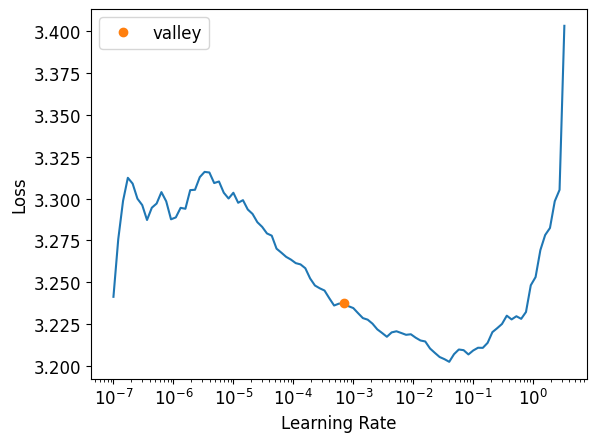

In [ ]:
learner_fc.lr_find(stop_div=False)

In [ ]:
Se usará $10^{-3}$ como LR.

epoch,train_loss,valid_loss,accuracy,time
0,3.037390,2.959524,0.208000,00:36
1,2.939112,2.839506,0.252000,00:35
2,2.835957,2.720980,0.249600,00:35
3,2.699521,2.533520,0.305600,00:35
4,2.576388,2.407325,0.338400,00:35
5,2.415838,2.170024,0.376000,00:35
6,2.330306,2.026572,0.382400,00:36
7,2.252192,1.976457,0.406400,00:37
8,2.188839,1.769952,0.462400,00:36
9,2.181641,1.960739,0.401600,00:39


No improvement since epoch 33: early stopping


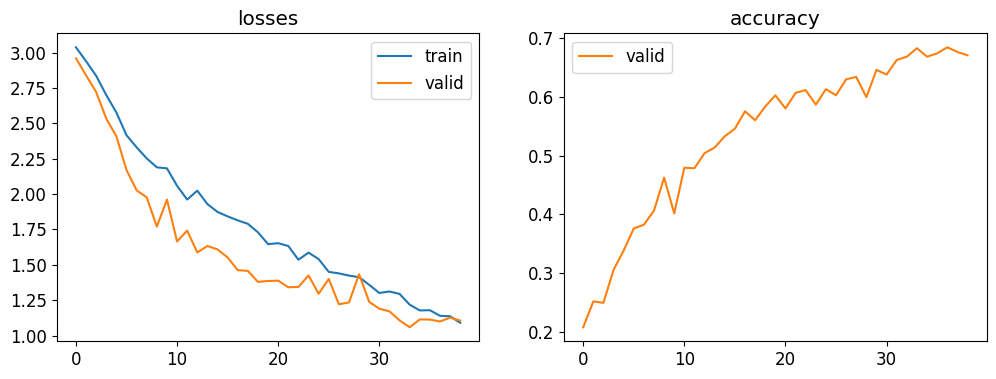

In [ ]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learner_fc.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learner_fc.recorder.plot_metrics()

Parece que los resultados son un poco mejores pero la subida de tiempo de entrenamiento hace que se descarte esta arquitectura.

##PRUEBA CON ADAPTIVE MAX POOL

A continuación, se va a probar AdaptiveMaxPool. Para reducir los parámetros de la capa completamente conectada.

In [ ]:
doc(nn.AdaptiveMaxPool2d)

Al realizar un MaxPool Adaptativo con tamaño 1, obtendremos el máximo de cada canal y nos quedaremos con 1 píxel por canal. Esto va a reducir el número de parámetros en la capa completamente conectada y además, acelerará el entrenamiento.

In [ ]:
BaseNet6 = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(1024, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),


    nn.Linear(50, 25),
)


learner_amp = Learner(dls_p1_imagenet, BaseNet6, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

In [ ]:
learner_amp.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 128 x 30 x 30  
Conv2d                                    3584       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 128 x 15 x 15  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 256 x 13 x 13  
Conv2d                                    295168     True      
BatchNorm2d                               512        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 512 x 11 x 11  
Conv2d                                    1180

El número de parámetros se ha reducido de 10M a 6M, el entrenamiento debería ir un poco más ligero.

SuggestedLRs(valley=0.001737800776027143)

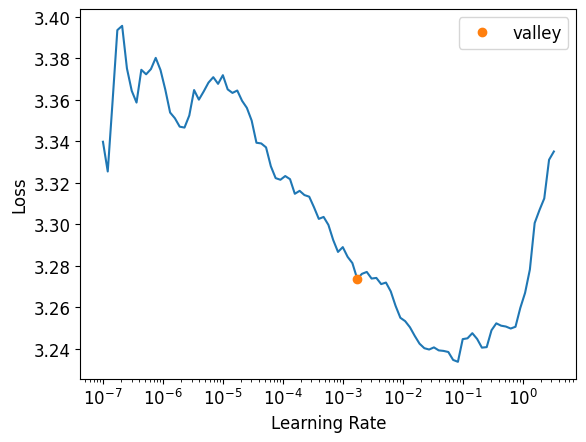

In [ ]:
learner_amp.lr_find(stop_div=False)

epoch,train_loss,valid_loss,accuracy,time
0,3.011250,2.894678,0.238400,00:22
1,2.897654,2.776735,0.282400,00:23
2,2.775827,2.613045,0.358400,00:27
3,2.670367,2.394661,0.393600,00:23
4,2.523441,2.365350,0.361600,00:26
5,2.362516,2.199711,0.352800,00:23
6,2.292187,2.004840,0.425600,00:24
7,2.166997,1.904938,0.438400,00:24
8,2.108192,1.828754,0.460800,00:22
9,2.040190,1.756858,0.464000,00:25


No improvement since epoch 36: early stopping


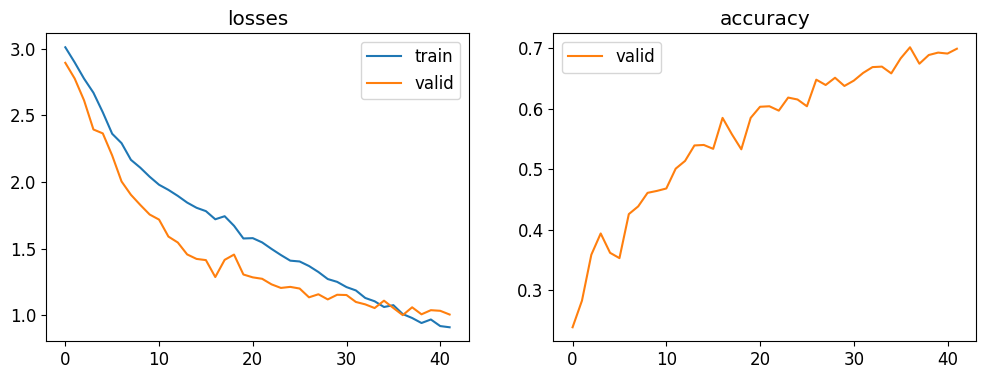

In [ ]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learner_amp.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learner_amp.recorder.plot_metrics()

Los tiempos en entrenamiento han mejorado. La red generaliza bien y se logra un Accuracy mejor al que se obtenía con la versión en la que se aplicó por primera vez Dropout, así que este será el modelo elegido.

##BATCH SIZE Y LR

Se va a probar el modelo final con un tamaño de batch de 128 y con LR's más grandes. Para ello se crean 3 DataLoaders distintos.

In [ ]:
db_train_b= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
)

dls_b = db_train_b.dataloaders(path/'train', bs=128)

BaseNet_b = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(1024, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),


    nn.Linear(50, 25),
)

copia1 = copy.deepcopy(BaseNet_b)
copia2 = copy.deepcopy(BaseNet_b)


learner_b = Learner(dls_b, BaseNet_b, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

learner_lr = Learner(dls_b, copia1, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

learner_lr_2 = Learner(dls_b, copia2, loss_func = CrossEntropyLossFlat(), metrics = accuracy)

# learner_b.lr_find(stop_div = False)

epoch,train_loss,valid_loss,accuracy,time
0,3.041389,2.947780,0.223200,00:16
1,2.927498,2.811136,0.270400,00:16
2,2.830926,2.717278,0.321600,00:16
3,2.751438,2.649031,0.340800,00:17
4,2.649385,2.504986,0.375200,00:16
5,2.520437,2.348541,0.392000,00:16
6,2.400887,2.205726,0.417600,00:17
7,2.276583,2.084501,0.449600,00:17
8,2.172305,1.962691,0.476000,00:16
9,2.069702,1.963128,0.455200,00:16


No improvement since epoch 37: early stopping


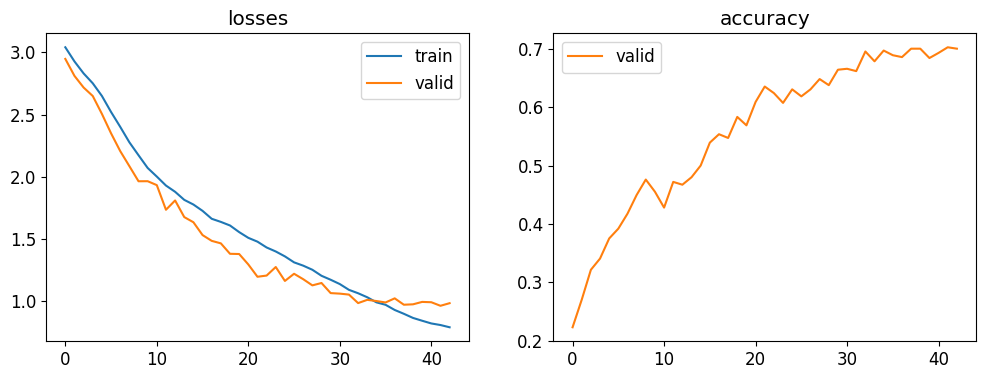

In [ ]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learner_b.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learner_b.recorder.plot_metrics()

Con un tamaño de batch mas grande, el entrenamiento es más rápido y se obtienen resultados parecidos en las mismas épocas. En adelante, se trabajará con este tamaño de batch para las pruebas que se harán.

epoch,train_loss,valid_loss,accuracy,time
0,2.965266,2.843424,0.151200,00:16
1,2.775003,2.795132,0.156800,00:19
2,2.670485,2.644209,0.215200,00:16
3,2.624448,2.540170,0.218400,00:15
4,2.562801,2.512621,0.227200,00:15
5,2.540047,2.374454,0.295200,00:16
6,2.523410,2.710019,0.181600,00:16
7,2.518899,2.704669,0.147200,00:17
8,2.510079,2.660812,0.159200,00:16
9,2.518571,2.897900,0.152800,00:16


No improvement since epoch 5: early stopping


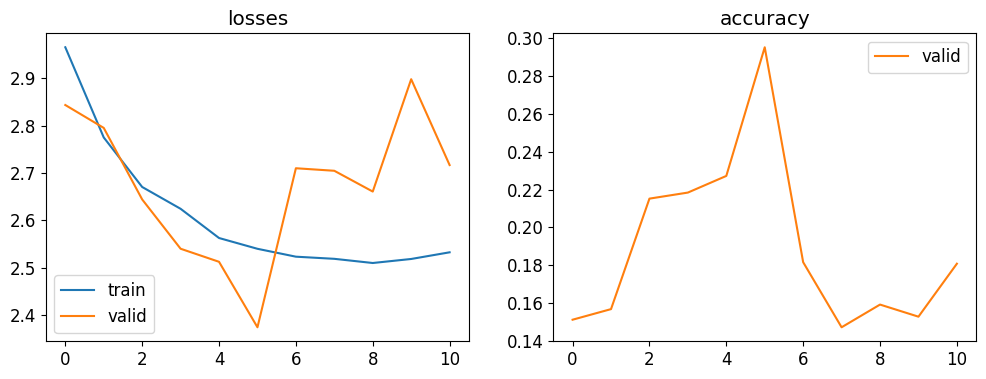

In [ ]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learner_lr.fit_one_cycle(50, lr_max = 10**-1, cbs=[es])
learner_lr.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,2.983020,2.836153,0.211200,00:16
1,2.791888,2.686194,0.221600,00:16
2,2.617308,2.402061,0.294400,00:16
3,2.469082,2.227439,0.325600,00:16
4,2.352857,2.059659,0.363200,00:16
5,2.266373,1.907068,0.422400,00:17
6,2.223153,1.923575,0.416000,00:16
7,2.165730,2.017299,0.372800,00:16
8,2.118944,2.036036,0.376800,00:16
9,2.086324,1.929334,0.399200,00:16


No improvement since epoch 41: early stopping


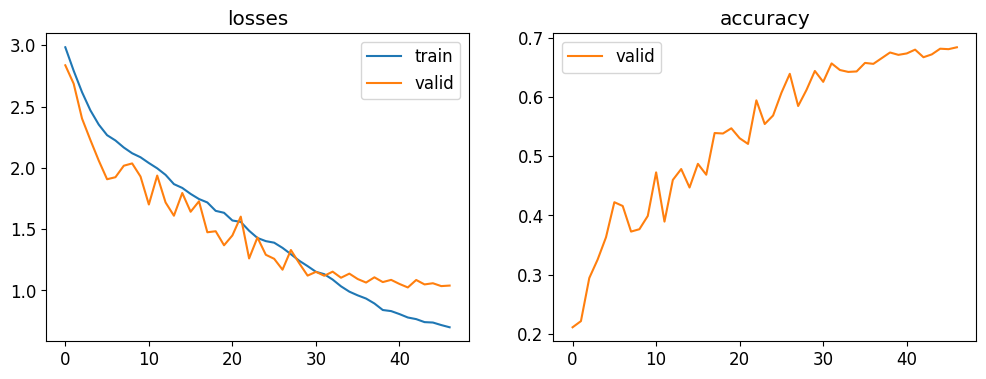

In [ ]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learner_lr_2.fit_one_cycle(50, lr_max = 10**-2, cbs=[es])
learner_lr_2.recorder.plot_metrics()

En cuanto a las pruebas para el LR, se descarta cualquiera de las dos. La primera ha otorgado muy malos resultados y la segunda ha producido overfitting.

##PRUEBA CON OPTIMIZADOR RMSProp

En un principio, se pensó en hacer una prueba con AdamW. No obstante, si revisamos la documentación de Adam:

In [ ]:
doc(Adam)

Al usar Adam sin modificar ningún parámetro, estamos usando AdamW, dado que por defecto decouple_wd viene a True se aplica weight decay (AdamW). Si se pusiera a False, se aplicaría L2 regularization (Adam).

Es por ello, que tras revisar la documentación, he decido probar con RMSProp.

A continuación, se detallarán las diferencias más importantes entre Adam y RMSProp.

Acumulación de gradientes y momentos:

+ Adam emplea la media móvil exponencial tanto de los gradientes (momento de primer orden) como de los cuadrados de los gradientes (momento de segundo orden) para ajustar las tasas de aprendizaje.
+ RMSProp, por otro lado, utiliza la media móvil exponencial solo de los cuadrados de los gradientes, destinándola exclusivamente a la adaptación de la tasa de aprendizaje y no al ajuste del momento.

Método de actualización de parámetros:

+ Adam fusiona la información tanto del momento de primer orden como del segundo orden para calcular una actualización de parámetros más efectiva.
+ En contraste, RMSProp se limita a utilizar la información del momento de segundo orden para ajustar la tasa de aprendizaje.

Tasa de aprendizaje adaptativa:

+ Adam ajusta la tasa de aprendizaje de manera individualizada para cada parámetro del modelo, aprovechando la información del momento de segundo orden.
+ RMSProp adapta la tasa de aprendizaje globalmente mediante la media móvil exponencial de los cuadrados de los gradientes acumulados.

Bias-correction en la actualización de parámetros:

+ Adam incorpora corrección de sesgo en las actualizaciones de los momentos de primer y segundo orden para contrarrestar el sesgo hacia cero en las primeras iteraciones.
+ Por su parte, RMSProp generalmente no aplica corrección de sesgo en la actualización de parámetros.

In [ ]:
db_train_b= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
)

dls_b = db_train_b.dataloaders(path/'train', bs=128)

BaseNet_b = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(1024, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),


    nn.Linear(50, 25),
)


learner_RMS = Learner(dls_b, BaseNet_b, loss_func = CrossEntropyLossFlat(), metrics = accuracy, opt_func=RMSProp)

SuggestedLRs(valley=0.00019054606673307717)

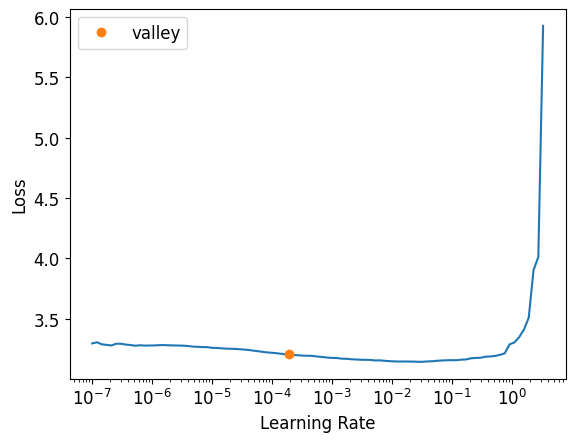

In [ ]:
learner_RMS.lr_find(stop_div=False)

LR = $10^{-3}$

epoch,train_loss,valid_loss,accuracy,time
0,2.966297,2.852561,0.264800,00:17
1,2.857410,2.776127,0.316000,00:17
2,2.775782,2.676973,0.328800,00:17
3,2.715027,2.649259,0.314400,00:17
4,2.632749,2.511554,0.392800,00:17
5,2.534220,2.436122,0.380800,00:17
6,2.415635,2.225224,0.386400,00:16
7,2.306411,2.115125,0.409600,00:17
8,2.226820,1.889381,0.452800,00:17
9,2.124610,1.983265,0.440800,00:17


No improvement since epoch 42: early stopping


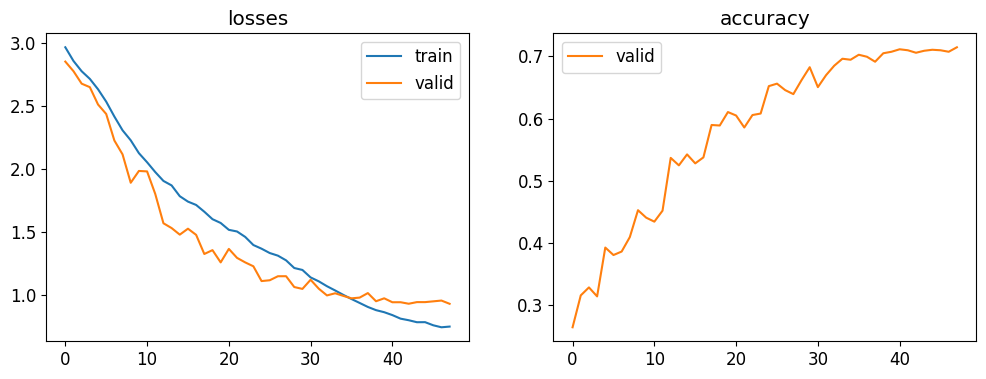

In [ ]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learner_RMS.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learner_RMS.recorder.plot_metrics()

Los resultados han sido mejores que los obtenidos con Adam en la ejecución anterior. Es por ello, que en adelante, se tomará este modelo como el modelo final.

Se ha obtenido más accuracy y menores valores de pérdida en las mismas épocas.

##PRUEBA CON LA INICIALIZACIÓN DE GLOROT

La inicialización de Glorot, también conocida como inicialización Xavier, es un método utilizado para inicializar los pesos de una red neuronal de manera que los gradientes no disminuyan ni aumenten exponencialmente a medida que se propagan hacia atrás durante el entrenamiento. Esta técnica fue propuesta por Xavier Glorot y Yoshua Bengio en su artículo "Understanding the difficulty of training deep feedforward neural networks".

No se detallará más al respecto, simplemente, se aplicará y probará para ver si obtenemos una mejora sustancial de los resultados. Se inicializarán los pesos de las capas convolucionales y lineales, que son los más numerosos de la red.

In [ ]:
# Initialize the weights using Glorot initialization
def glorot_init(m):
    if isinstance(m, nn.Linear) or \
        isinstance(m,nn.Conv2d) :
        nn.init.xavier_uniform_(m.weight)

db_train_b= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
)

dls_glorot = db_train_b.dataloaders(path/'train', bs=128)

BaseNet_glorot = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(1024, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),


    nn.Linear(50, 25),
)

BaseNet_glorot.apply(glorot_init)

learner_glorot = Learner(dls_glorot, BaseNet_glorot, loss_func = CrossEntropyLossFlat(), metrics = accuracy, opt_func=RMSProp)


SuggestedLRs(valley=0.001737800776027143)

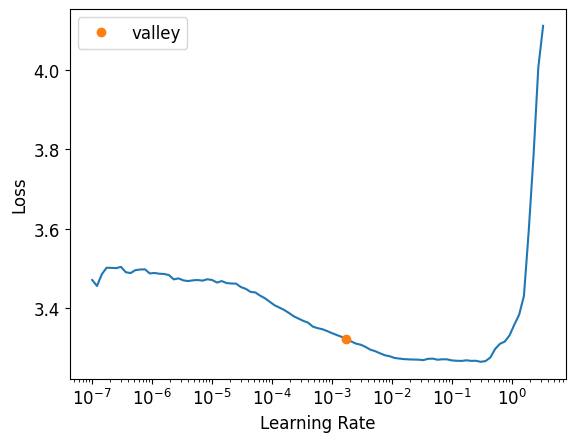

In [ ]:
learner_glorot.lr_find(stop_div=False)

LR = $10^{-3}$

epoch,train_loss,valid_loss,accuracy,time
0,2.998142,2.779991,0.246400,00:19
1,2.825994,2.563868,0.305600,00:18
2,2.722138,2.483321,0.337600,00:18
3,2.646706,2.388468,0.338400,00:19
4,2.579771,2.303695,0.387200,00:18
5,2.490232,2.207210,0.399200,00:18
6,2.425267,2.177498,0.424000,00:17
7,2.347271,2.003247,0.443200,00:17
8,2.273635,1.963405,0.450400,00:17
9,2.202980,1.961304,0.434400,00:16


No improvement since epoch 38: early stopping


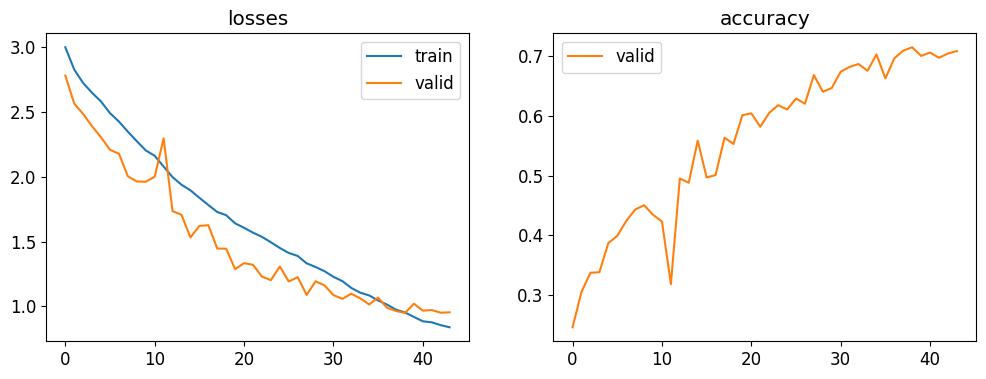

In [ ]:
learner_glorot.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learner_glorot.recorder.plot_metrics()

Como se puede observar, no se ha obtenido una mejora sustancial con respecto a la prueba anterior, así que no se optará por esta forma de inicializar de inicio los pesos de la red. A continuación, se probará el modelo final, con AdaptiveMaxPooling y RMSProp como optimizador.

##MODELO FINAL



In [ ]:
db_train_final= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    batch_tfms=[IntToFloatTensor(),*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
)

dls_final = db_train_final.dataloaders(path/'train', bs=128)

BaseNet_final = nn.Sequential(
    nn.Conv2d(3,128,3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128,256,3),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256,512,3),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(1024, 50),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(50),
    nn.ReLU(),


    nn.Linear(50, 25),
)


learner_final = Learner(dls_final, BaseNet_final, loss_func = CrossEntropyLossFlat(), metrics = accuracy, opt_func=RMSProp)

SuggestedLRs(valley=9.120108734350652e-05)

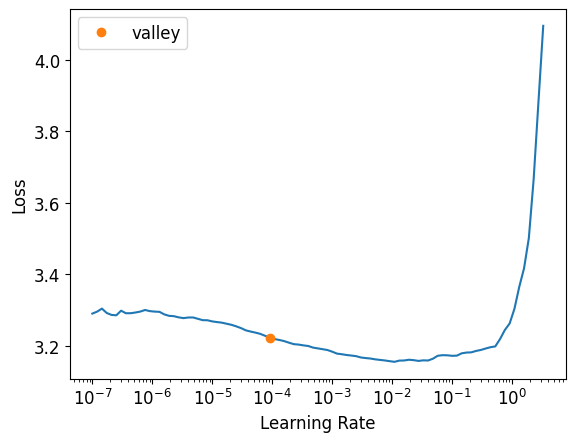

In [ ]:
learner_final.lr_find(stop_div=False)

Parece que un LR de $10^{-3}$ es adecuado (igual que en la ejecución de prueba).

Para esta última ejecución, se usará el callback SaveModel. En este caso, irá midiendo por defecto el error de validación y si mejora en 0.01, será el nuevo mejor modelo.

Se guardará el modelo como model_final, aunque se cargará por defecto al terminar el entrenamiento por lo que no hace falta cargarlo manualmente para Test.

In [ ]:
sm = SaveModelCallback(min_delta = 0.01, fname="model_final")
learner_final.fit_one_cycle(50, lr_max = 10**-3, cbs=[es,sm])

epoch,train_loss,valid_loss,accuracy,time
0,2.969121,2.875144,0.264000,00:17
1,2.864502,2.826644,0.263200,00:17
2,2.777034,2.649709,0.332000,00:17
3,2.717496,2.602669,0.372000,00:17
4,2.630410,2.471517,0.362400,00:16
5,2.521712,2.401642,0.344000,00:17
6,2.405569,2.327428,0.385600,00:16
7,2.298806,2.102838,0.433600,00:17
8,2.206582,2.117176,0.393600,00:16
9,2.123844,1.926410,0.463200,00:16


Better model found at epoch 0 with valid_loss value: 2.8751442432403564.
Better model found at epoch 1 with valid_loss value: 2.8266444206237793.
Better model found at epoch 2 with valid_loss value: 2.649709463119507.
Better model found at epoch 3 with valid_loss value: 2.6026690006256104.
Better model found at epoch 4 with valid_loss value: 2.4715170860290527.
Better model found at epoch 5 with valid_loss value: 2.401642084121704.
Better model found at epoch 6 with valid_loss value: 2.327427625656128.
Better model found at epoch 7 with valid_loss value: 2.1028378009796143.
Better model found at epoch 9 with valid_loss value: 1.9264097213745117.
Better model found at epoch 10 with valid_loss value: 1.8108124732971191.
Better model found at epoch 12 with valid_loss value: 1.7137337923049927.
Better model found at epoch 13 with valid_loss value: 1.6581244468688965.
Better model found at epoch 14 with valid_loss value: 1.6189453601837158.
Better model found at epoch 15 with valid_loss val

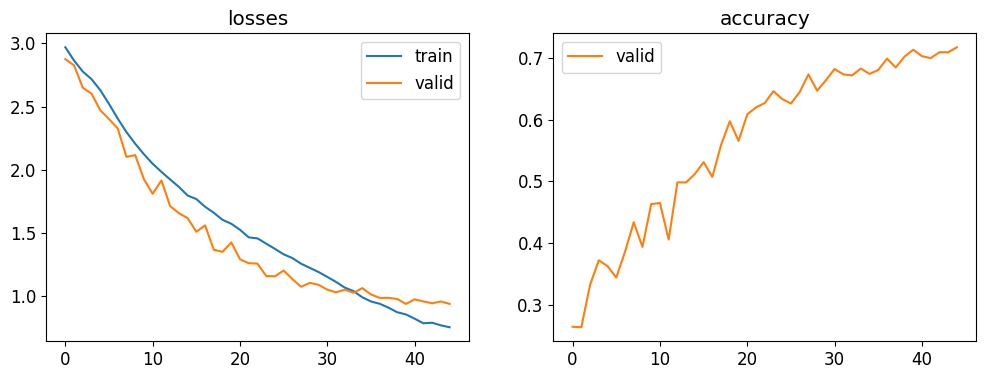

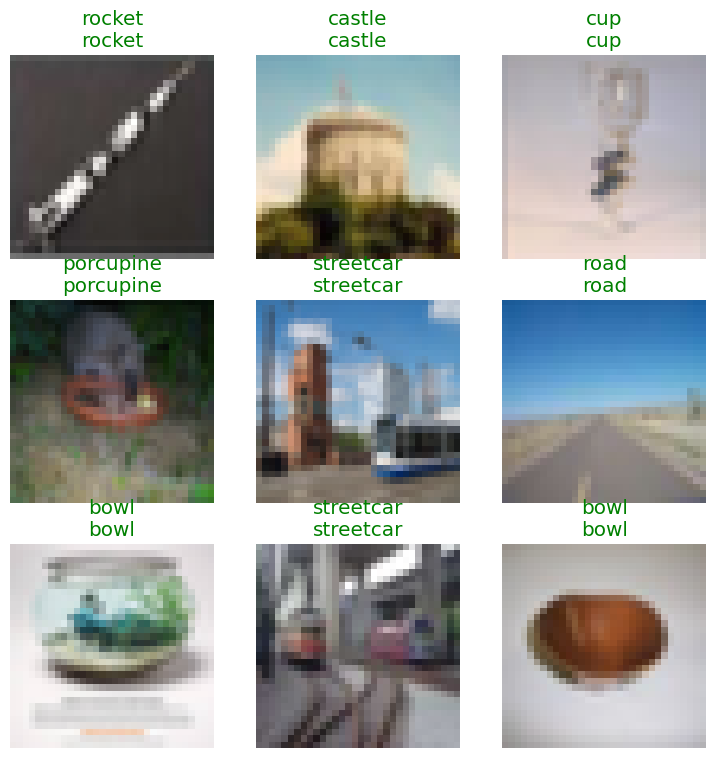

In [ ]:
learner_final.recorder.plot_metrics()

learner_final.show_results()

Se produce al final del entrenamiento un poco de Overfitting. No obstante, los resultados son buenos, logrando en torno a un 70% de accuracy en validación.

Aunque se agoten las 50 épocas y no se produzca Early Stopping, no sería conveniente entrenar más épocas, ya que el comportamiento al final ha empeorado.

##PREDICCIONES DEL MODELO EN TEST

El mejor modelo ya estará cargado en nuestro Learner, así, para no dejar nada en disco, se borra el modelo que previamente se ha guardado.

In [ ]:
if os.path.exists("/content/models/model_final.pth"):
    # Borrar el archivo
    os.remove("/content/models/model_final.pth")

Hay que tener en cuenta, que todas las transformaciones que se hayan hecho a los datos antes de entrenar, también se tienen que aplicar en test. (Todas menos data augmentation).

En la documentación de test_dl, dice: Create a test dataloader from test_items using validation transforms of dls.

Es decir, todas las trasnformaciones que se apliquen en validación, se aplicarán en test, en nuestro caso, la normalización.



In [ ]:

# We perform prediction on this bunch of data (in this case, the validation set)
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]
test_dl = learner_final.dls.test_dl(test_files,with_labels=True)

preds, targs, _ = learner_final.get_preds(dl=test_dl, with_decoded=True)
preds2, targs2, _ = learner_final.get_preds(dl=learner_final.dls.train, with_decoded=True)
preds3, targs3, _ = learner_final.get_preds(dl=learner_final.dls.valid, with_decoded=True)
# We compute accuracy
acc_test = accuracy(preds, targs)
acc_train = accuracy(preds2,targs2)
acc_valid = accuracy(preds3, targs3)
print('The test accuracy is : ', round(float(acc_test)*100, 4), '%')
print('The train accuracy is : ', round(float(acc_train)*100, 4), '%')
print('The validation accuracy is : ', round(float(acc_valid)*100, 4), '%')

The test accuracy is :  71.68 %
The train accuracy is :  82.9778 %
The validation accuracy is :  71.36 %


Number of train examples: 11250


Number of test examples: 2500


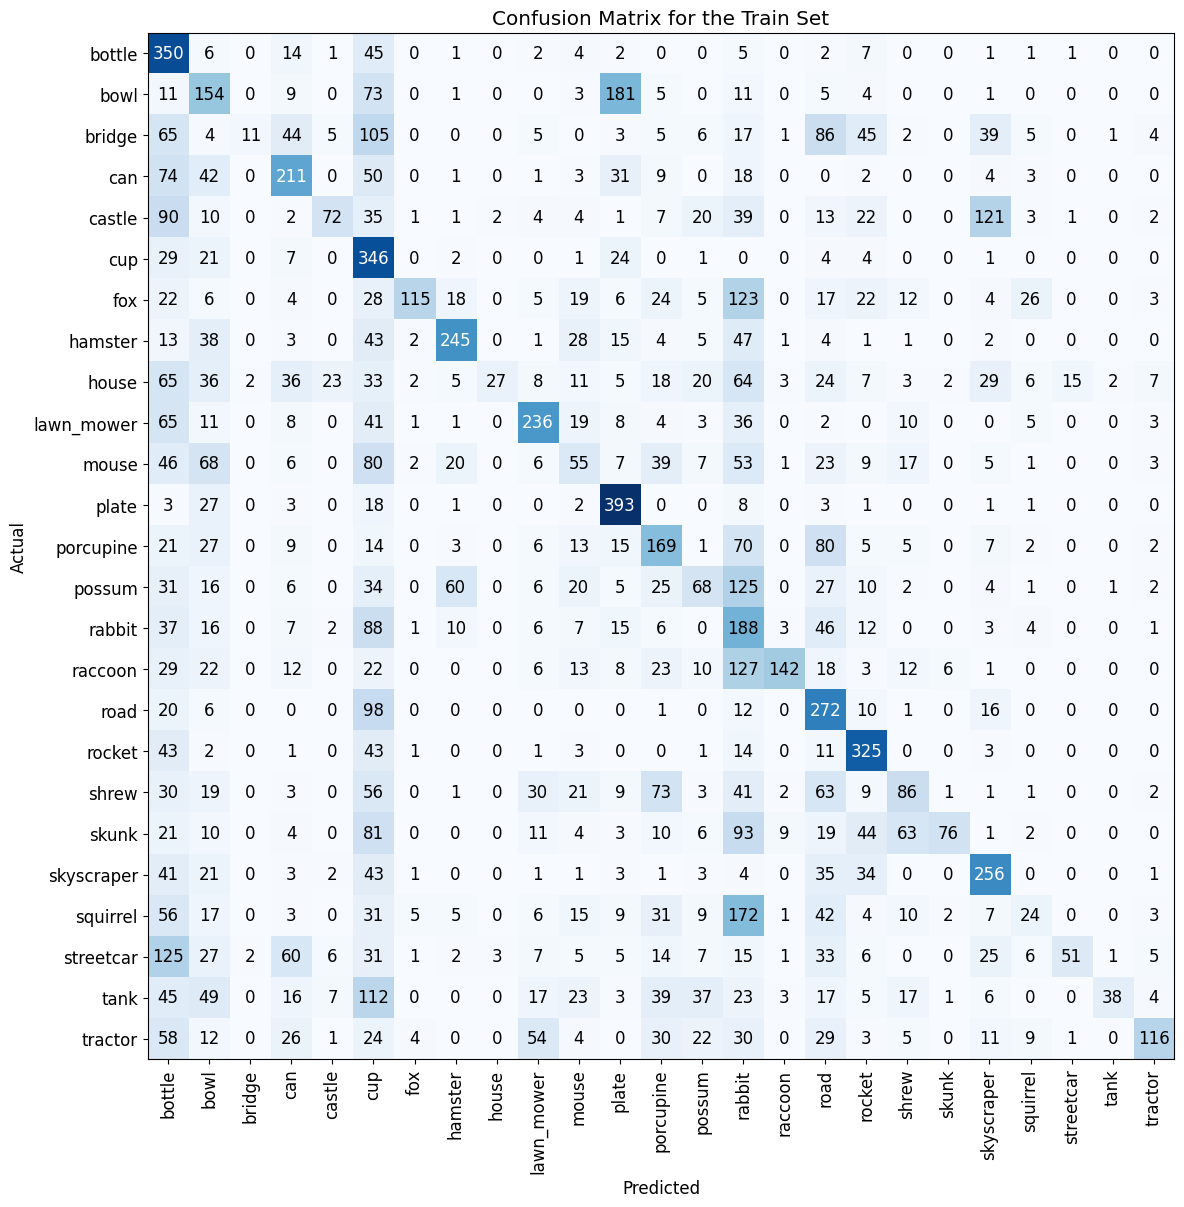

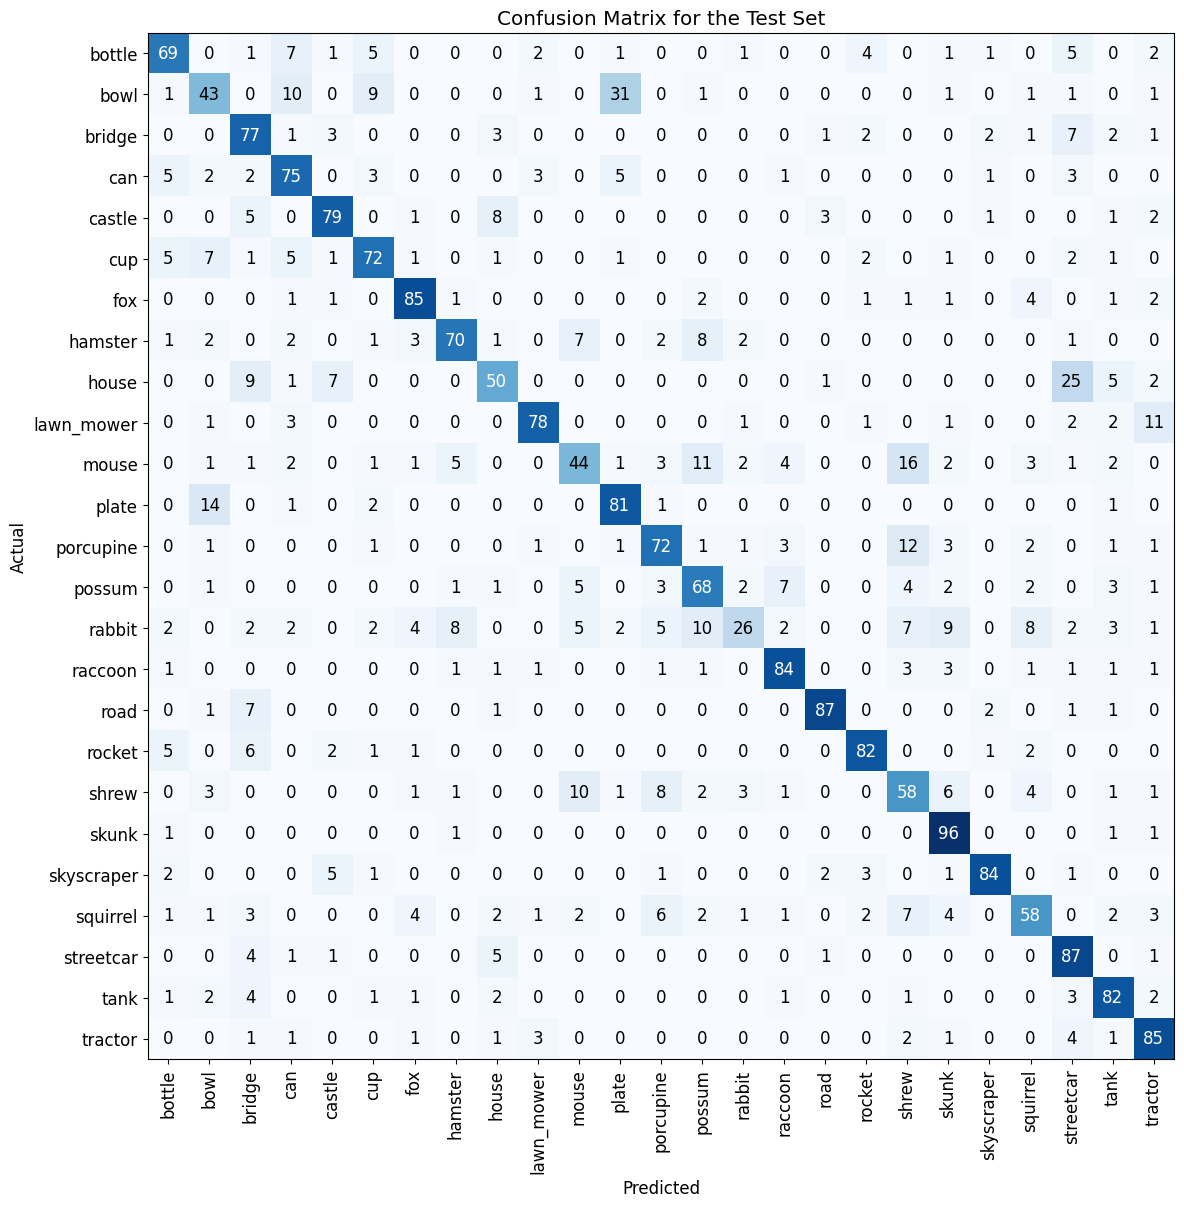

In [ ]:
interp = ClassificationInterpretation.from_learner(learner_final, 1, dls.train)
cm = interp.confusion_matrix()
print('Number of train examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')

# We compute the confusion matrix for test
interp = ClassificationInterpretation.from_learner(learner_final, 1, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')

Hemos mejorado los resultados del ejercicio 1 en torno a un 40%, haciendo entrenamientos desde 0 y con una arqutectura propia. Además, la matriz de confusión tiene mejor pinta que la del ejercicio 1. La diagonal principal refleja muchos más aciertos.

Esto hace ver la gran potencia que tiene el Deep Learning y todos los recursos que se pueden usar. De hecho, para hacer la práctica, se han descartado sistemáticamente pruebas para no hacerla muy extensa o porque se pensaba que no iban a tener una gran repercusión.

Por ejemplo, se podría haber probado con otra inicialización de los pesos u otro optimizador. Se podría haber optado por algún otro tipo de Data Augmentation como MixUp, también por adaptive AVG Pool en vez del Max Pool, o una concatenación de las dos (como la cabecera por defecto de FastaAI para Fine Tuning).

No obstante, creo que el resultado de la práctica ha sido satisfactorio. Haciendo pruebas intuitivas y lógicas, como si la red neuronal de una cabeza humana se tratase, se han logrado mejorar los resultados sin más esfuerzo que el de escribir bien el código e ir esperando los diferentes entrenamientos. Además. dada la amplitud del campo que estamos trabajando, se podría seguir probando opciones casi de manera indefinida (nuevas capas, nuevos LR, modificar parámetros del Optimizador, modificar parámetros de la función de entrenamiento, etc).